# H12 locus artwork 

## Setup

In [1]:
%run locus-artwork-setup.ipynb

In [2]:
def plot_signal_percentiles(pop):
    fig, ax = plt.subplots(facecolor='w', figsize=(10, 3))
    
    # plot each chromosome
    x = np.arange(80, 100)
    all_signals = []
    for c in '2', '3', 'X':
        # load gwss data
        _, _, _, signal, _, _ = load_h12_gwss(pop, c)
        all_signals.append(signal)
        # plot 
        y = [np.percentile(signal, i) for i in x]
        ax.plot(x, y, marker='o', label=c)
        
    # plot all
    signal = np.concatenate(all_signals)
    y = [np.percentile(signal, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
    ax.set_ylim(bottom=0, top=0.4)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$H12$')
    ax.set_title(pop_defs[pop]['label'])
    
    plt.show()
    plt.close()
    

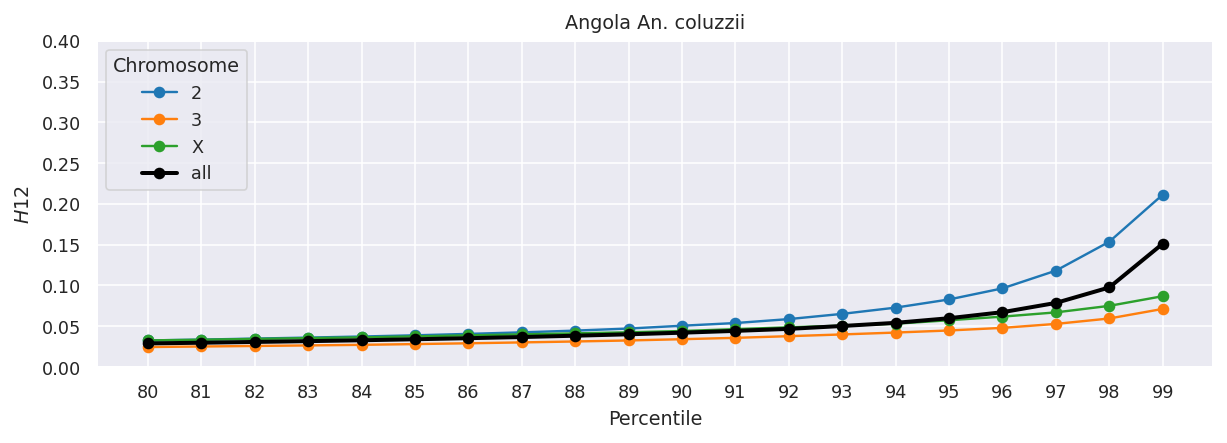

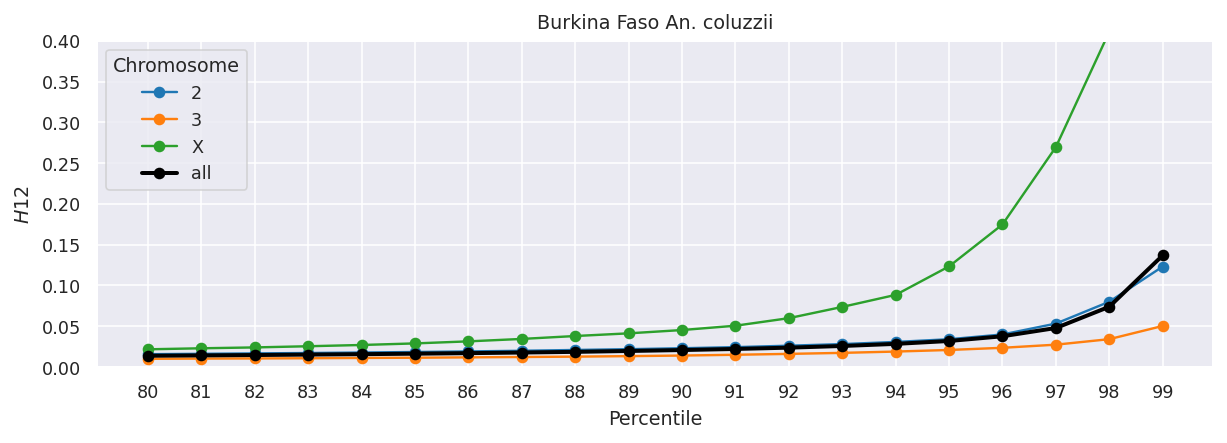

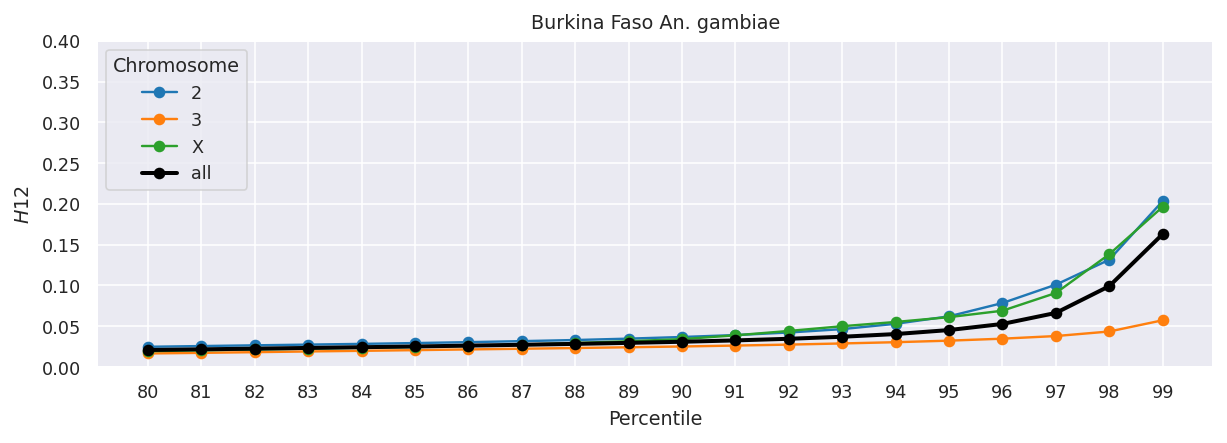

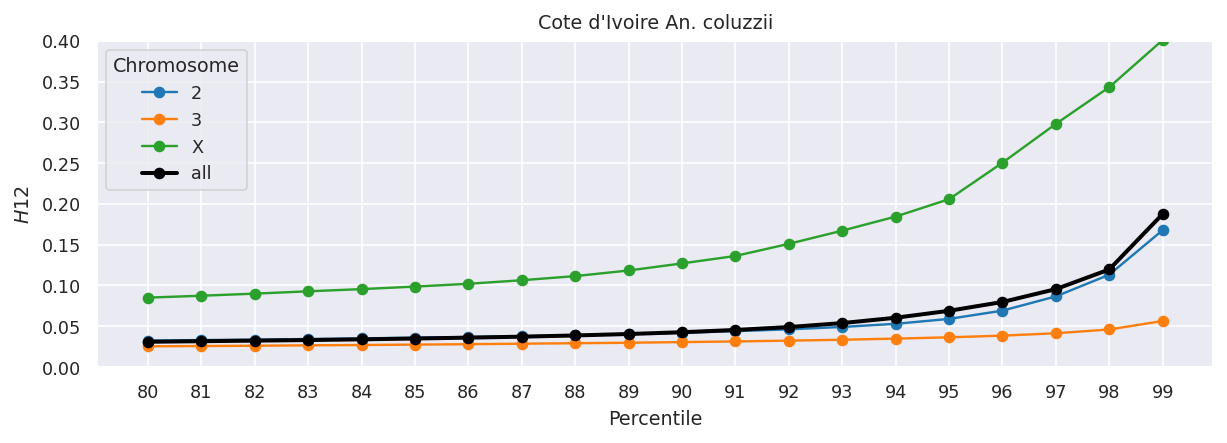

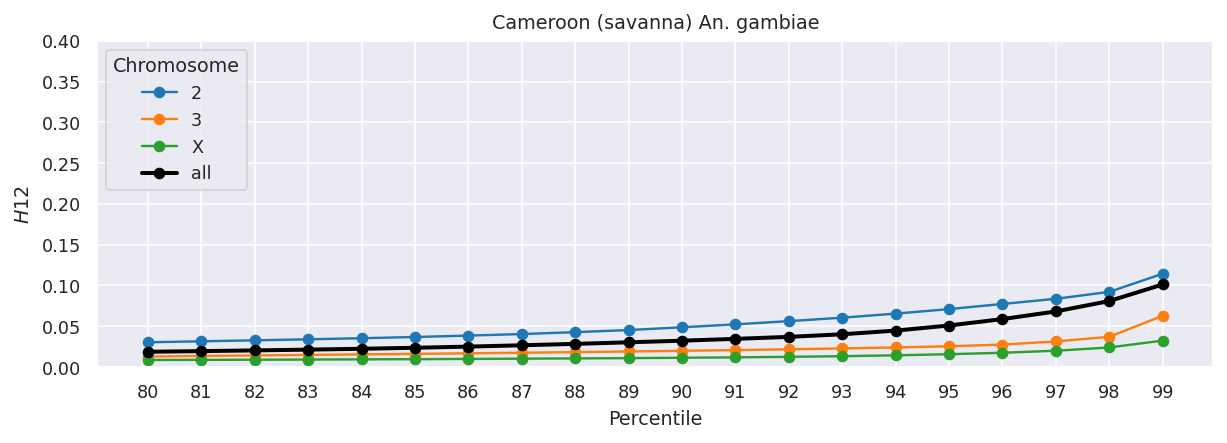

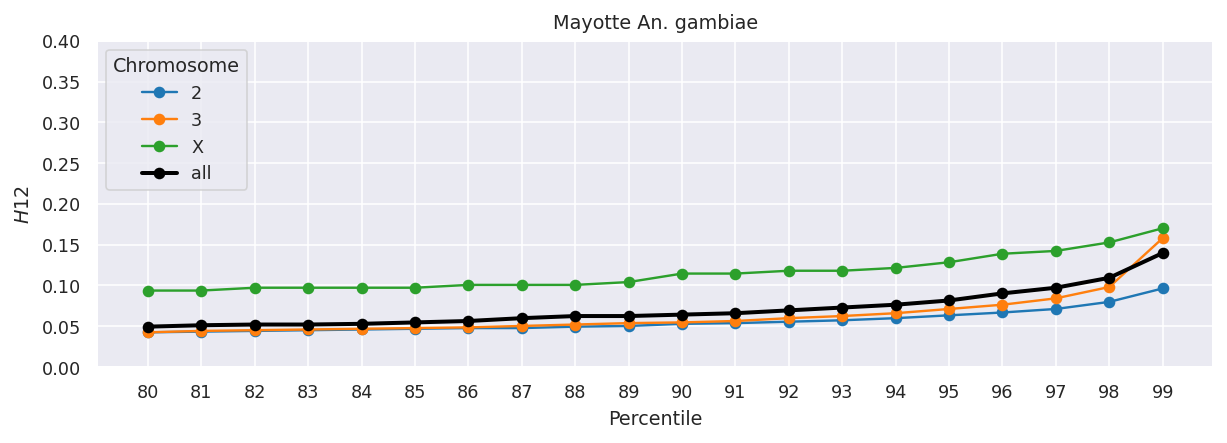

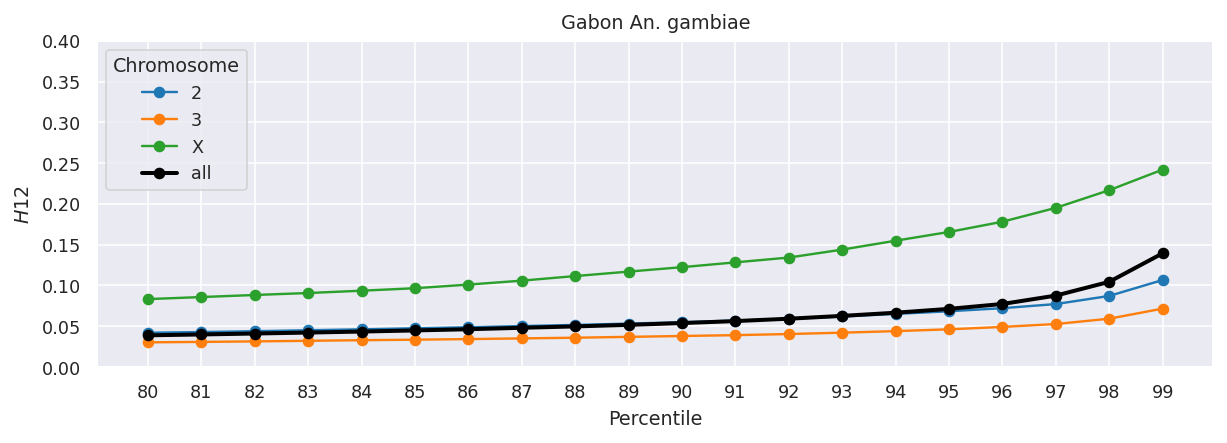

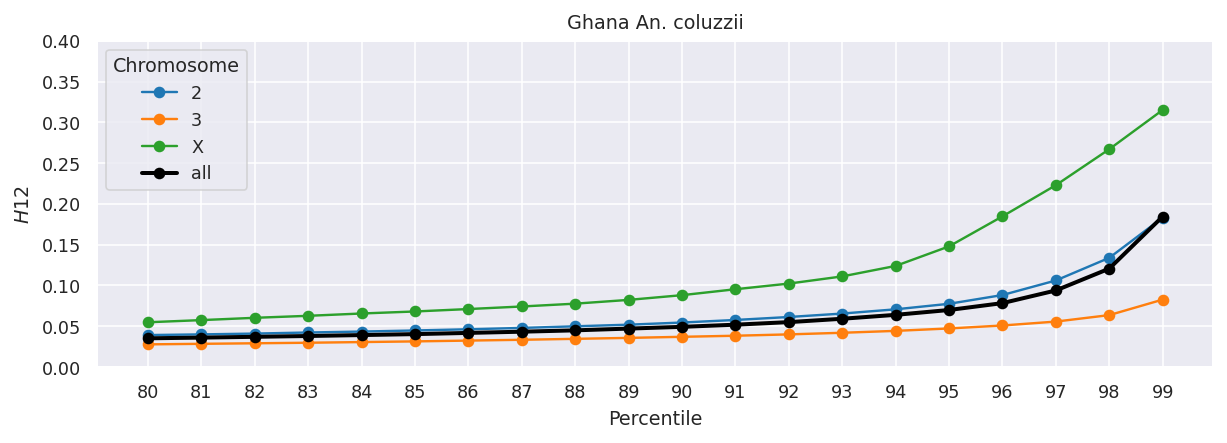

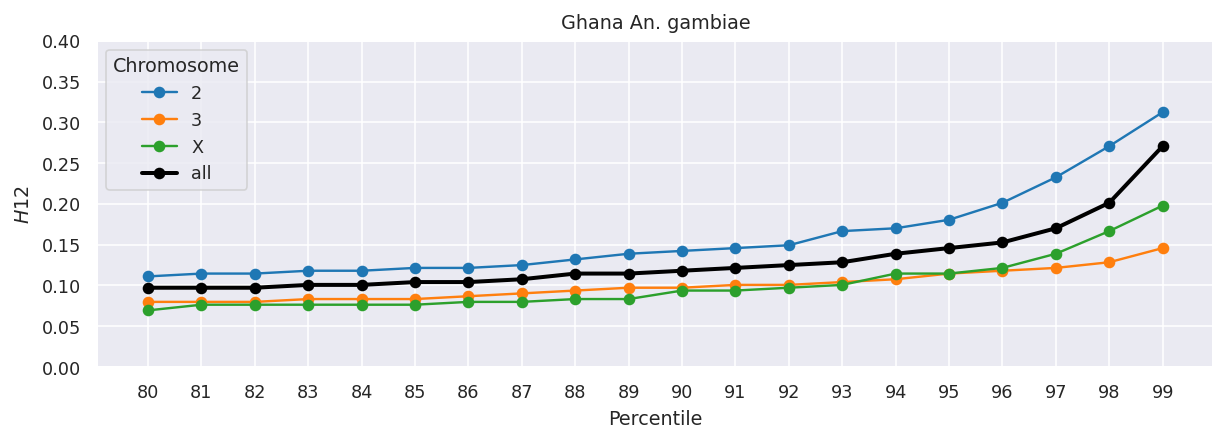

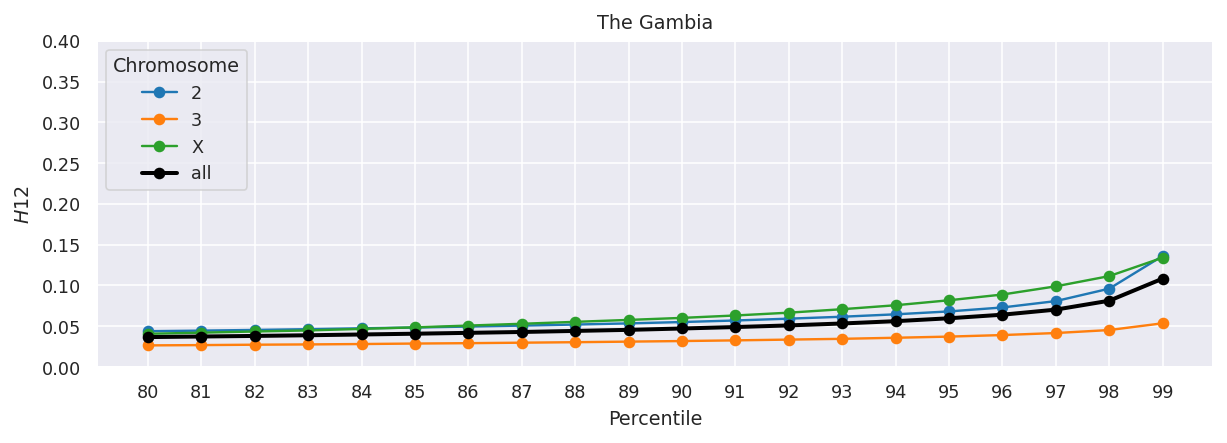

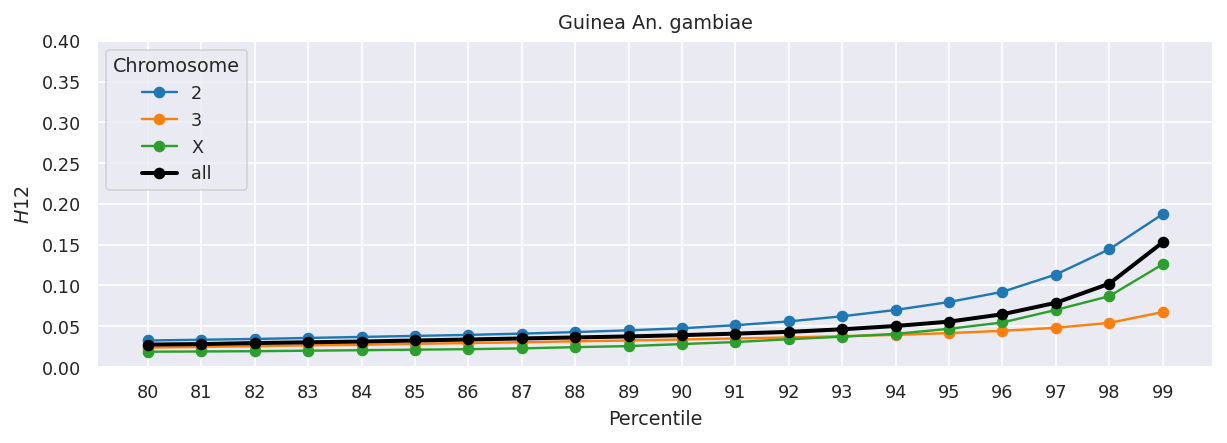

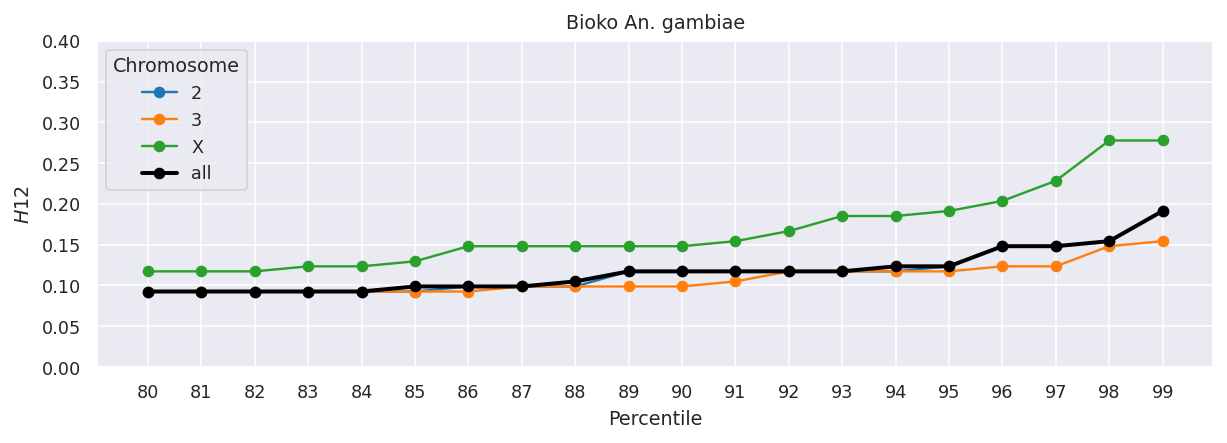

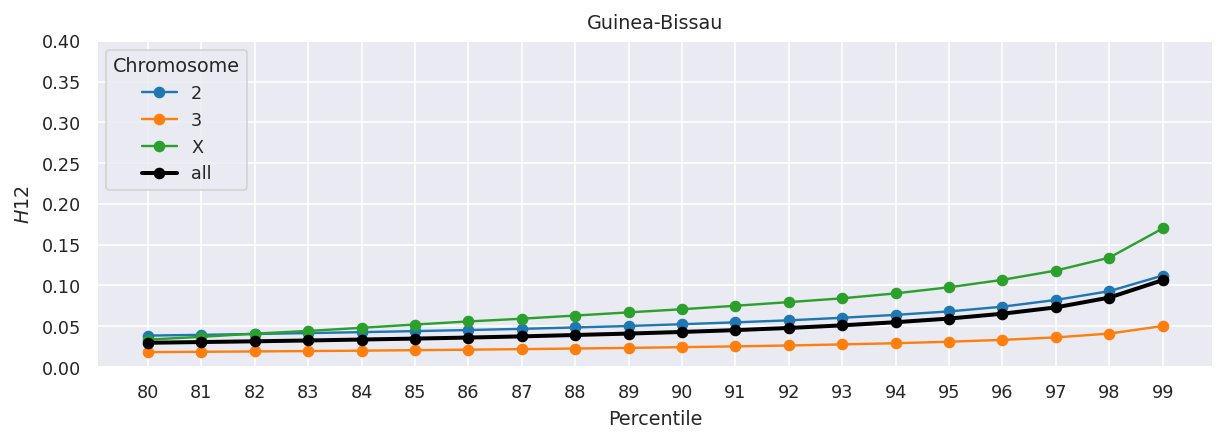

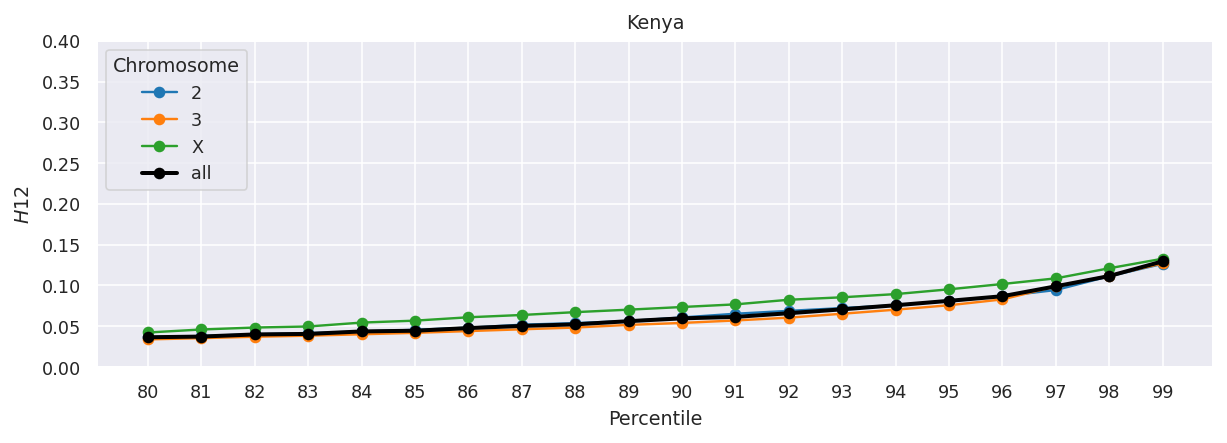

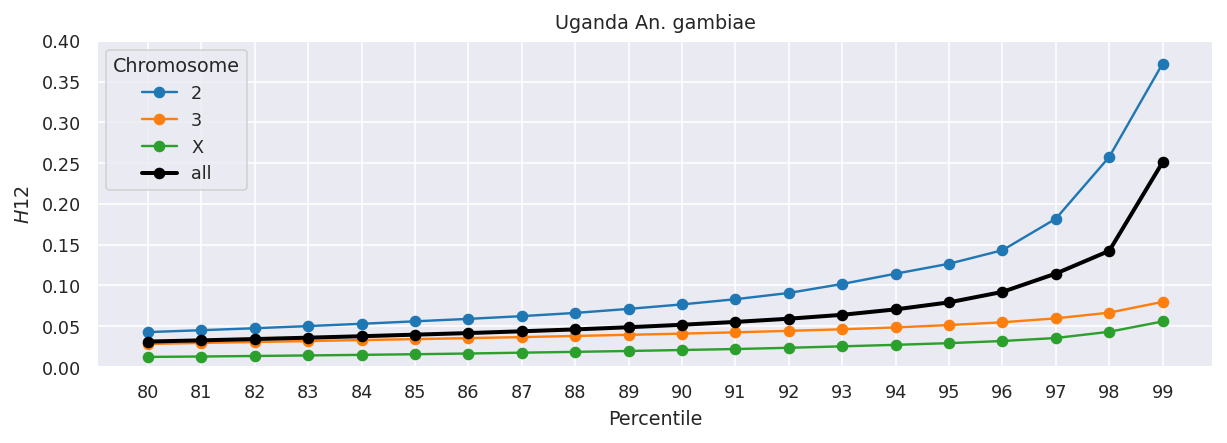

In [3]:
for pop in pop_defs:
    plot_signal_percentiles(pop)

In [4]:
@functools.lru_cache(maxsize=None)
def get_signal_percentile(pop, q):
    signals = []
    for c in '2', '3', 'X':
        # load gwss data
        _, _, _, signal, _, _ = load_h12_gwss(pop, c)
        signals.append(signal)
    signal = np.concatenate(signals)
    return np.percentile(signal, q)
    

In [5]:
def plot_signal(pop, chromosome, center, flank, ymax=None, ax=None,  
                markersize=2, genetic_distance=False, label=True,
                median_filter=0, has_peak_n=20, has_peak_dist=.2, 
                percentiles=[98]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
        
    # load gwss data
    windows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    if median_filter:
        signal = scipy.ndimage.median_filter(signal, size=median_filter, mode='wrap')
    p = windows.mean(axis=1)/1e6
    gp = gwindows.mean(axis=1)
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p
        
    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_signal_percentile(pop, q)
        qvals.append(v)
        ax.axhline(v, color='gray', linestyle='--', lw=1)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot data
    palette = sns.color_palette()
    ax.plot(x, signal, linestyle=' ', marker='o', color=palette[0], 
            markersize=markersize, label='$H12$')

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        ymax = max(0.3, 1.1*qvals[-1], 1.1*np.max(signal[loc_xlim]))
    ax.set_ylim(0, ymax)
    ax.set_ylabel('$H12$')
    pop_label = (
        pop_defs[pop]["label"]
        .replace('An. gambiae', '$An. gambiae$')
        .replace('An. coluzzii', '$An. coluzzii$')
    )
    
    # statistics
    loc_peak_test = allel.SortedIndex(p).locate_range(center-has_peak_dist, center+has_peak_dist)
    has_peak = np.count_nonzero(signal[loc_peak_test] > qvals[-1]) > has_peak_n
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-.5, center+.5)
        peak_value = np.max(signal[loc_region])
        peak_pos = p[loc_region][np.argmax(signal[loc_region])] - center
        statistics = dict(
            pop=pop,
            peak_value=peak_value,
            peak_pos=peak_pos,
        )
    else:
        statistics = dict(
            pop=pop,
            peak_value=np.nan,
            peak_pos=np.nan,
        )
    
    if label:
        if has_peak:
            annotation = (
                f"{pop_label}\n"
                f"$H12_{{peak}}={peak_value:.2f}$\n"
                f"$pos(H12_{{peak}})={peak_pos*1e3:+.1f}$ kbp"
            )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xycoords='axes fraction',
                    xytext=(8, -8), textcoords='offset points', 
                    fontsize=8, ha='left', va='top', backgroundcolor='w')
            
    return statistics
    

In [21]:
all_stats = dict()


def analyse_gene(gene, flank=1.5, genetic_distance=False):
    
    # first pass, plot all populations
    df_stats = fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'], track_height=2, 
        genetic_distance=genetic_distance,
        plot_kwargs=dict(ymax=1),
        tracks=(
            (plot_signal, dict(pop='bf_gam')),
            (plot_signal, dict(pop='gn_gam')),
            (plot_signal, dict(pop='gh_gam')),
            (plot_signal, dict(pop='cm_sav_gam')),
            (plot_signal, dict(pop='ug_gam')),
            (plot_signal, dict(pop='ga_gam')),
            (plot_signal, dict(pop='gq_gam')),
            (plot_signal, dict(pop='fr_gam')),
            (plot_signal, dict(pop='bf_col')),
            (plot_signal, dict(pop='ci_col')),
            (plot_signal, dict(pop='gh_col')),
            (plot_signal, dict(pop='ao_col')),
            (plot_signal, dict(pop='gw')),
            (plot_signal, dict(pop='gm')),
            (plot_signal, dict(pop='ke')),
        ),
    )
    plt.show()
    plt.close()
    
    # store stats
    all_stats[gene['Name'].lower()] = df_stats
    
    # find pops with peak
    peak_pops = df_stats[~df_stats.peak_value.isna()]['pop'].values
    
    if len(peak_pops) < 6:
        track_height = 2.3
    else:
        track_height = None

    # second pass, plot only pops with a peak
    fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'],
        genetic_distance=genetic_distance,
        track_height=track_height,
        tracks=[(plot_signal, dict(pop=pop)) for pop in peak_pops],
        savefig=here() / f"artwork/locus_{gene['Name'].lower()}_h12_{'g' if genetic_distance else 'p'}dist.png"
    )  
    plt.show()
    plt.close()
    

## *Gste2*

In [22]:
gste2

seqid                            3R
source                   VectorBase
type                           gene
start                      28597652
end                        28598640
score                            -1
strand                            -
phase                            -1
Name                          Gste2
biotype              protein_coding
chromosome                        3
chromosome_start           28597652
chromosome_end             28598640
chromosome_center       2.85981e+07
Name: AGAP009194, dtype: object

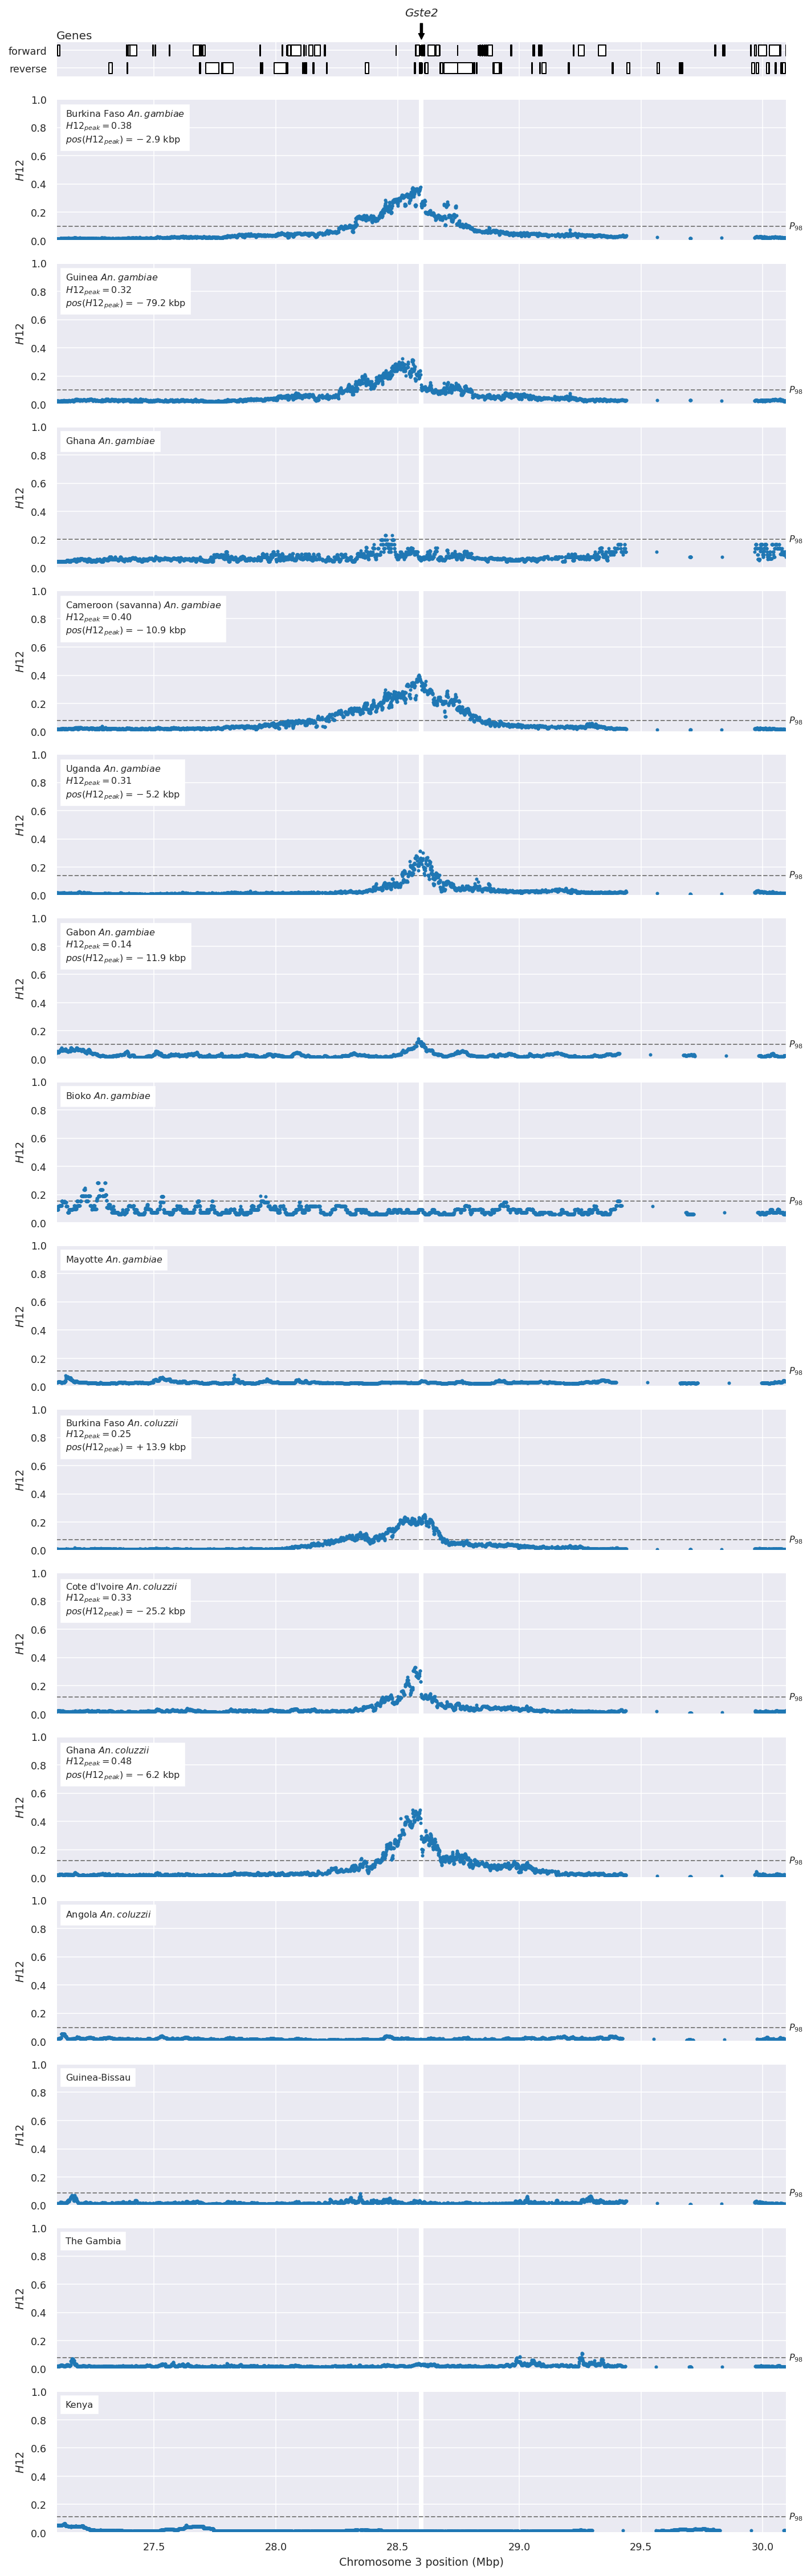

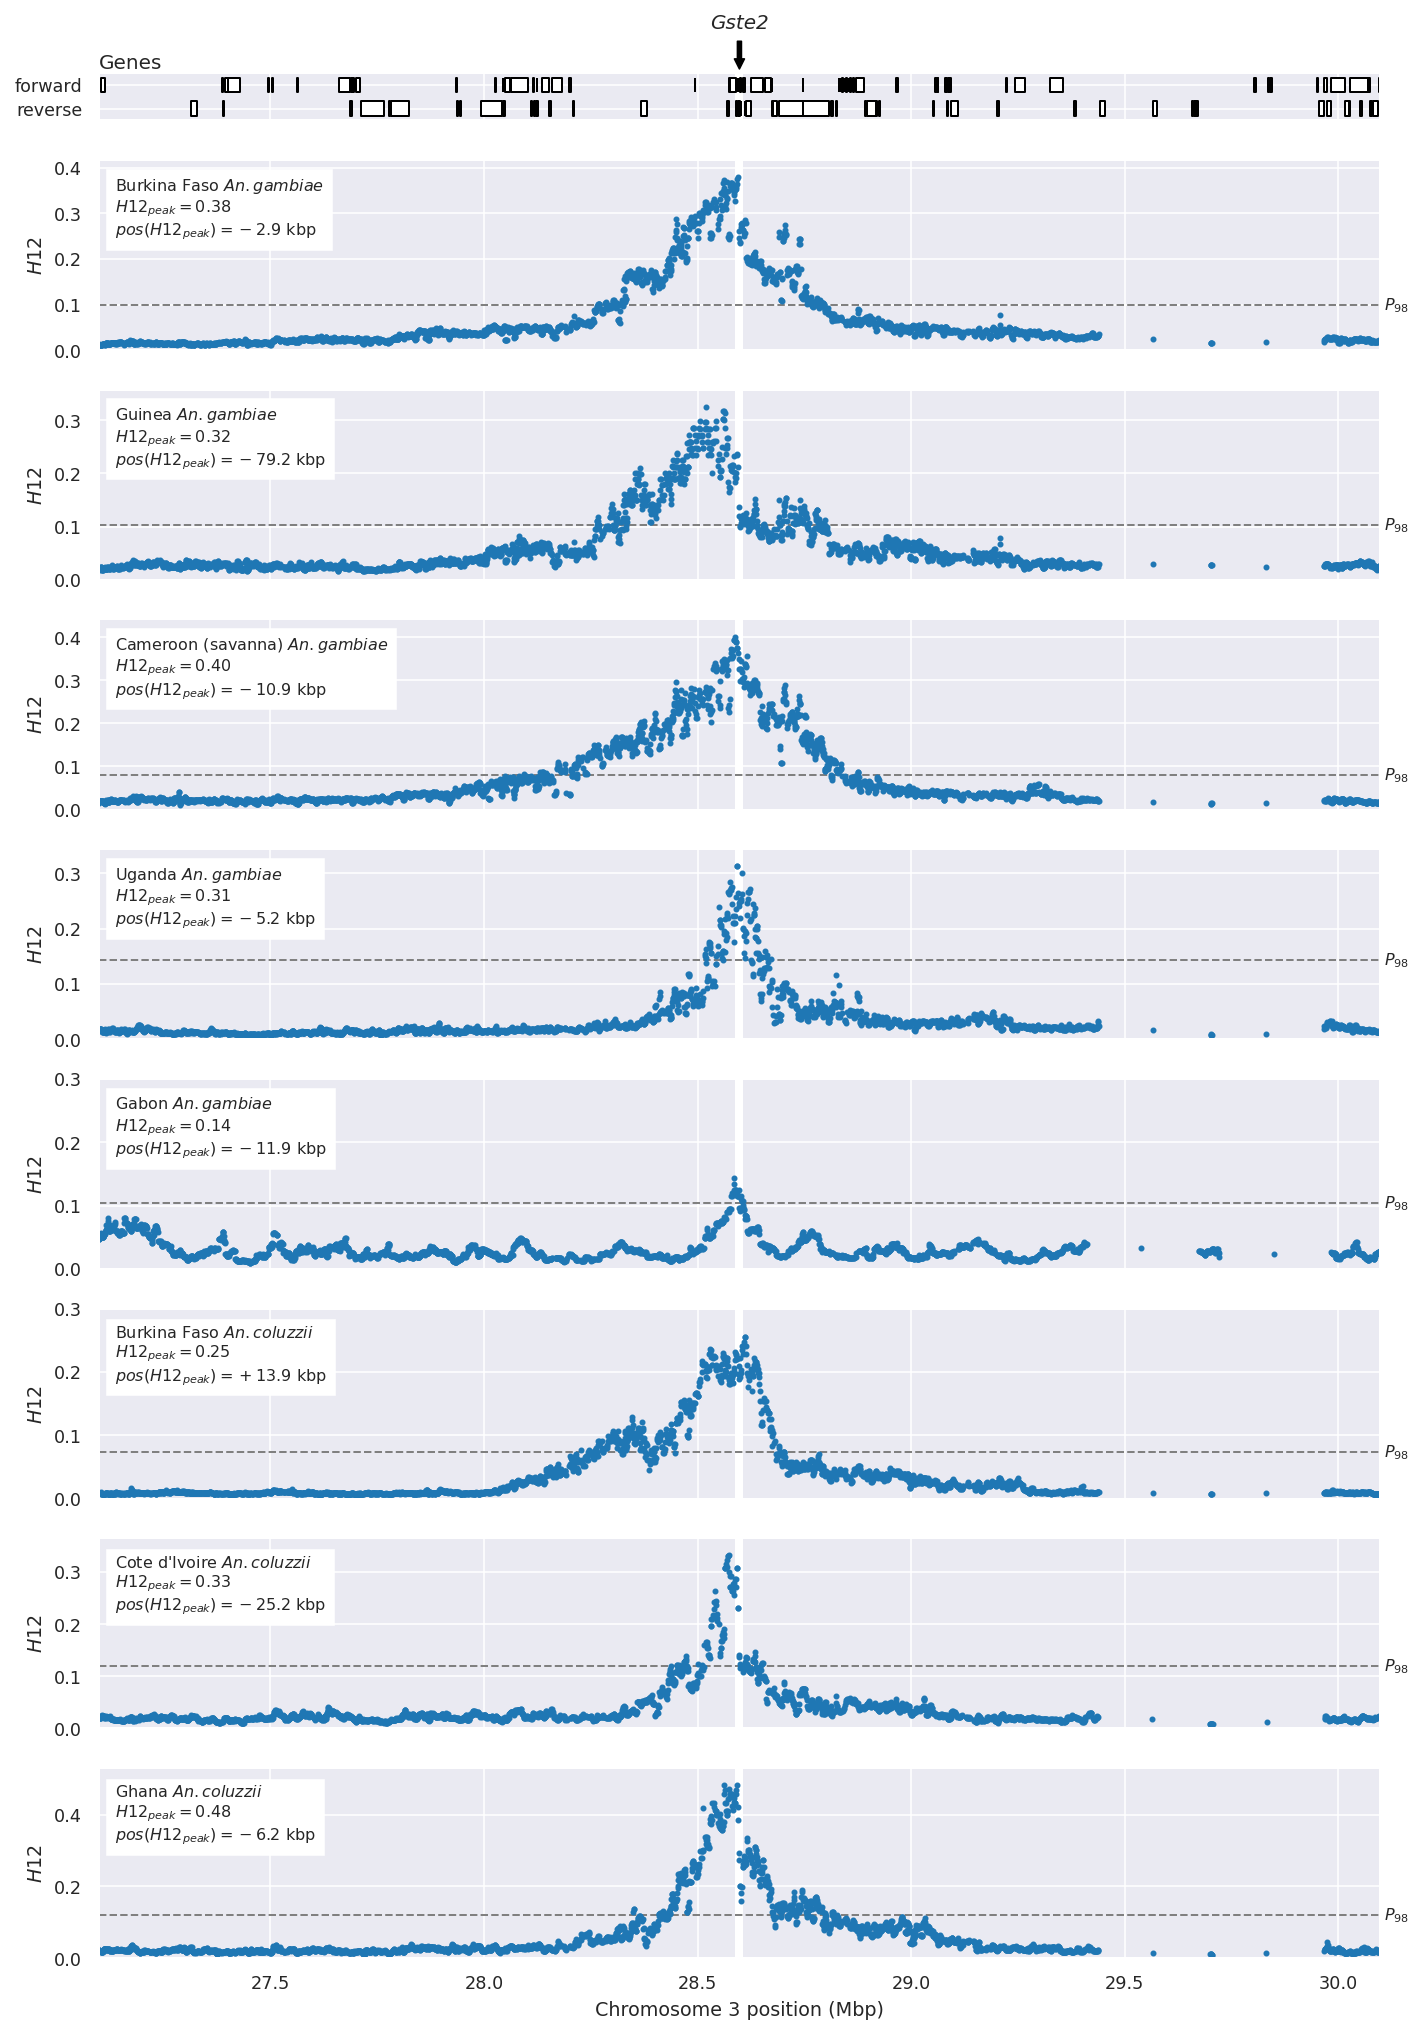

In [23]:
analyse_gene(gste2)

## *Cyp6p3*

In [24]:
cyp6p3

seqid                            2R
source                   VectorBase
type                           gene
start                      28491415
end                        28493141
score                            -1
strand                            -
phase                            -1
Name                         Cyp6p3
biotype              protein_coding
chromosome                        2
chromosome_start           28491415
chromosome_end             28493141
chromosome_center       2.84923e+07
Name: AGAP002865, dtype: object

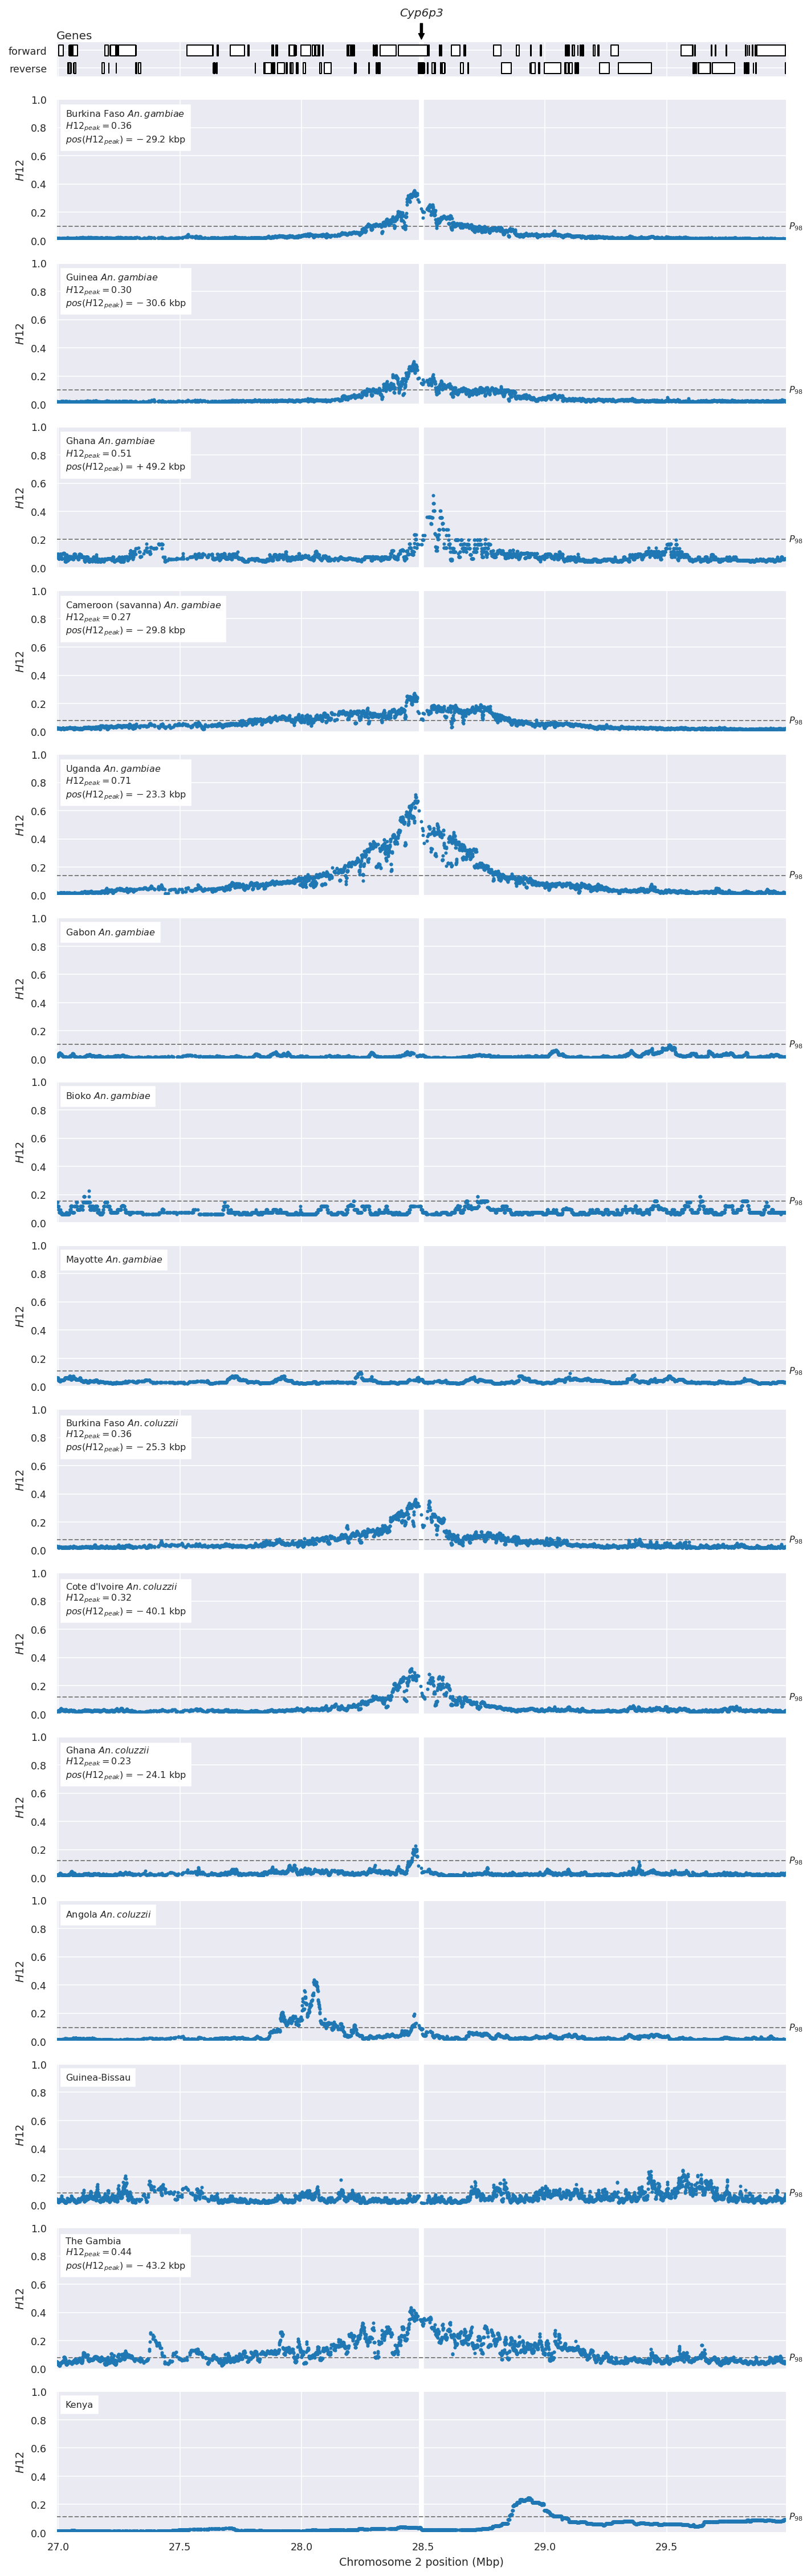

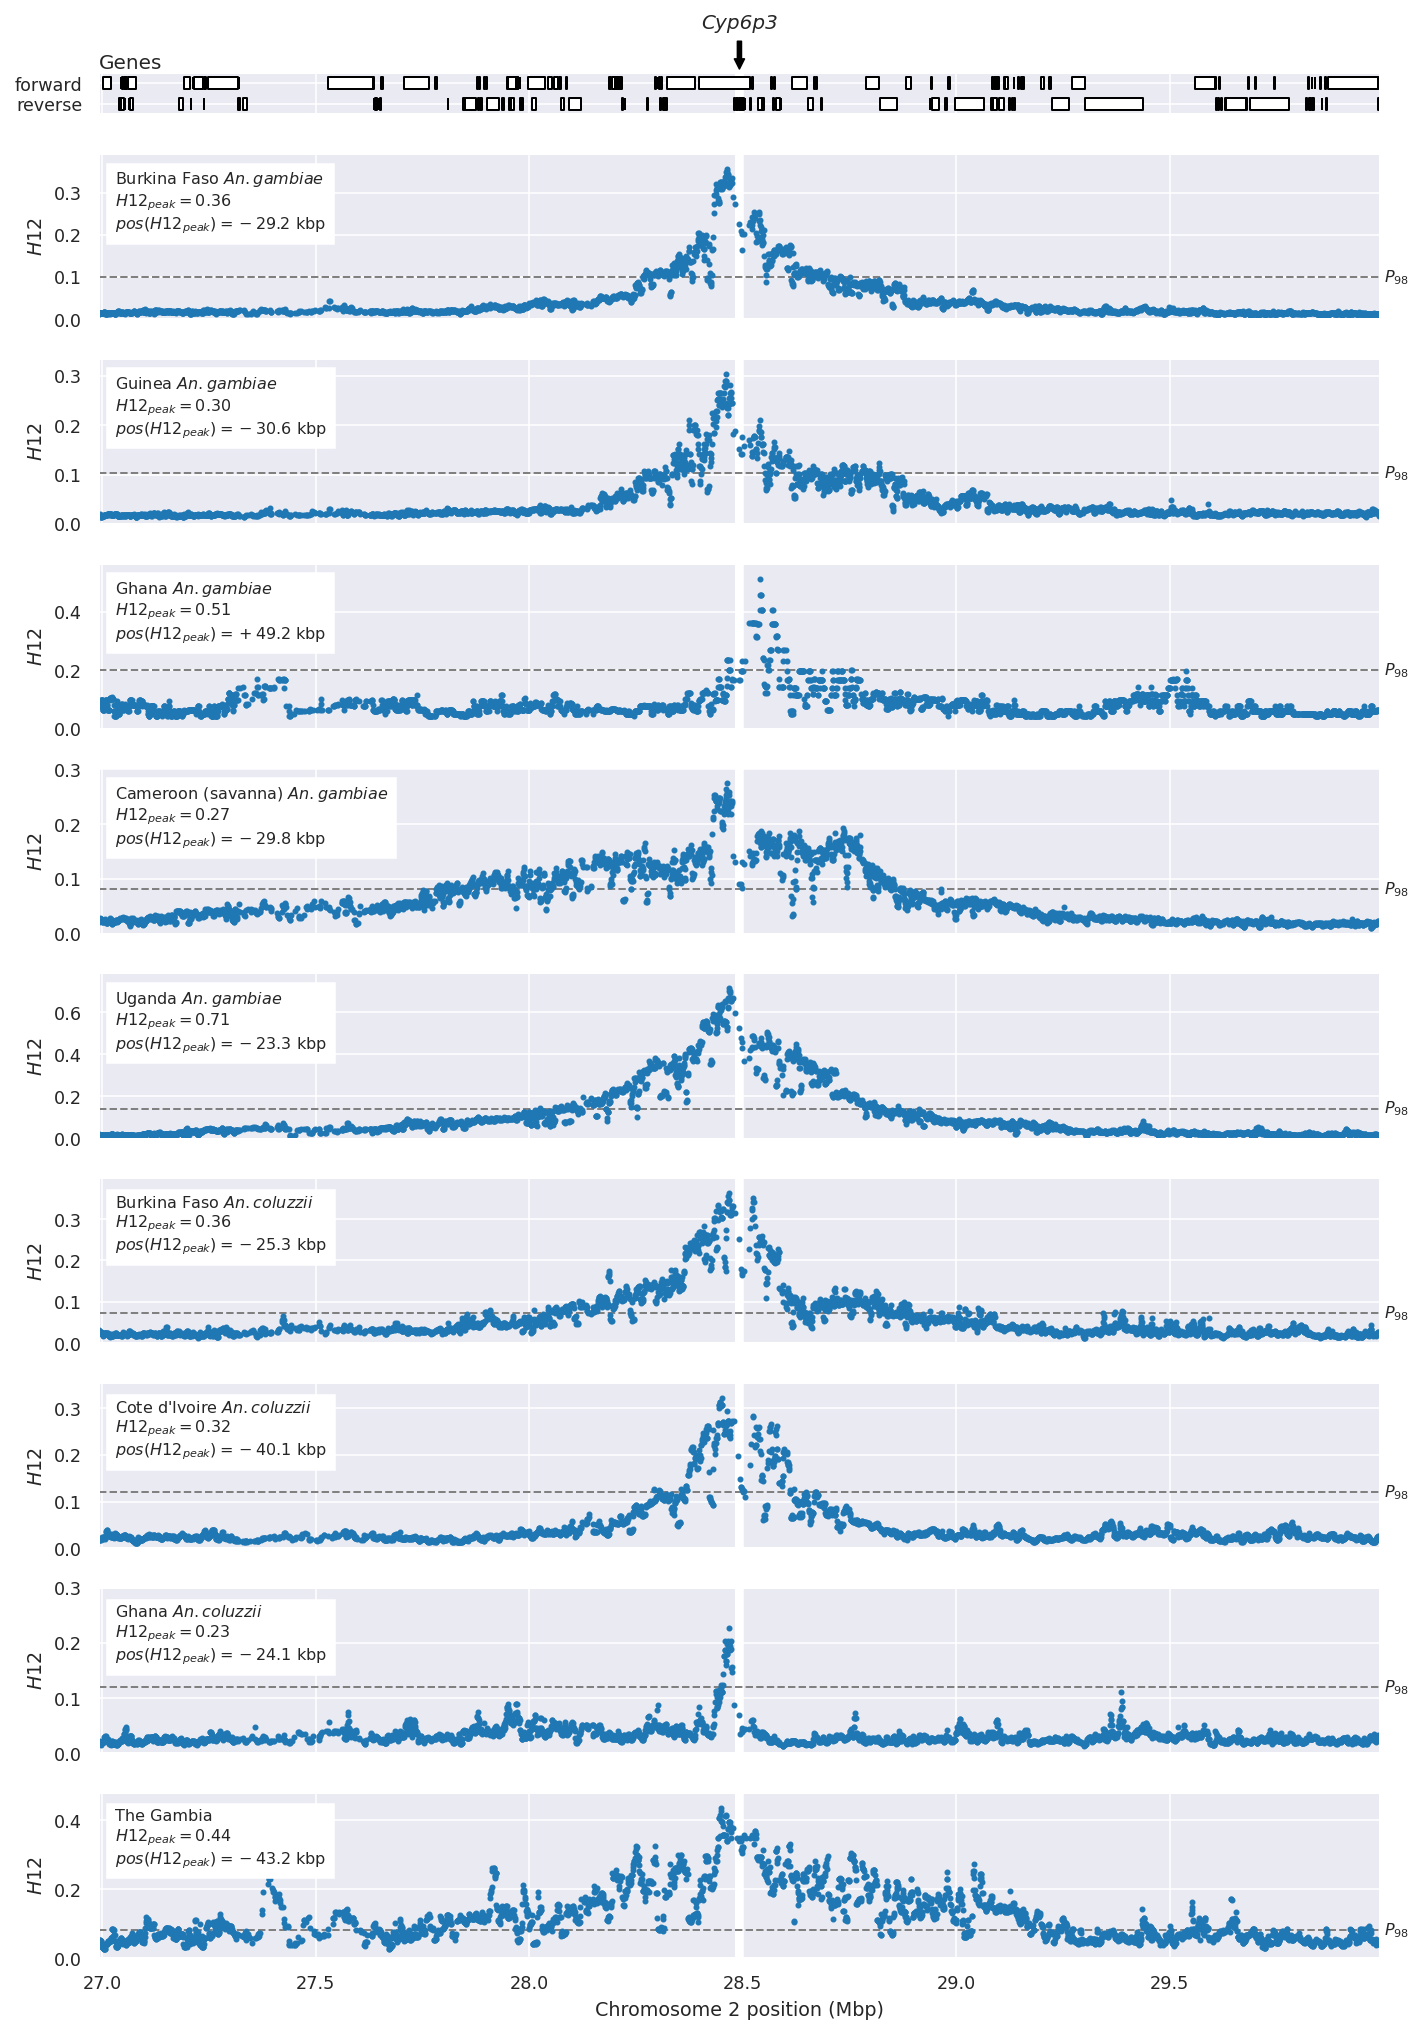

In [25]:
analyse_gene(cyp6p3)

## *Cyp9k1*

In [26]:
cyp9k1

seqid                             X
source                   VectorBase
type                           gene
start                      15240572
end                        15242864
score                            -1
strand                            -
phase                            -1
Name                         Cyp9k1
biotype              protein_coding
chromosome                        X
chromosome_start           15240572
chromosome_end             15242864
chromosome_center       1.52417e+07
Name: AGAP000818, dtype: object

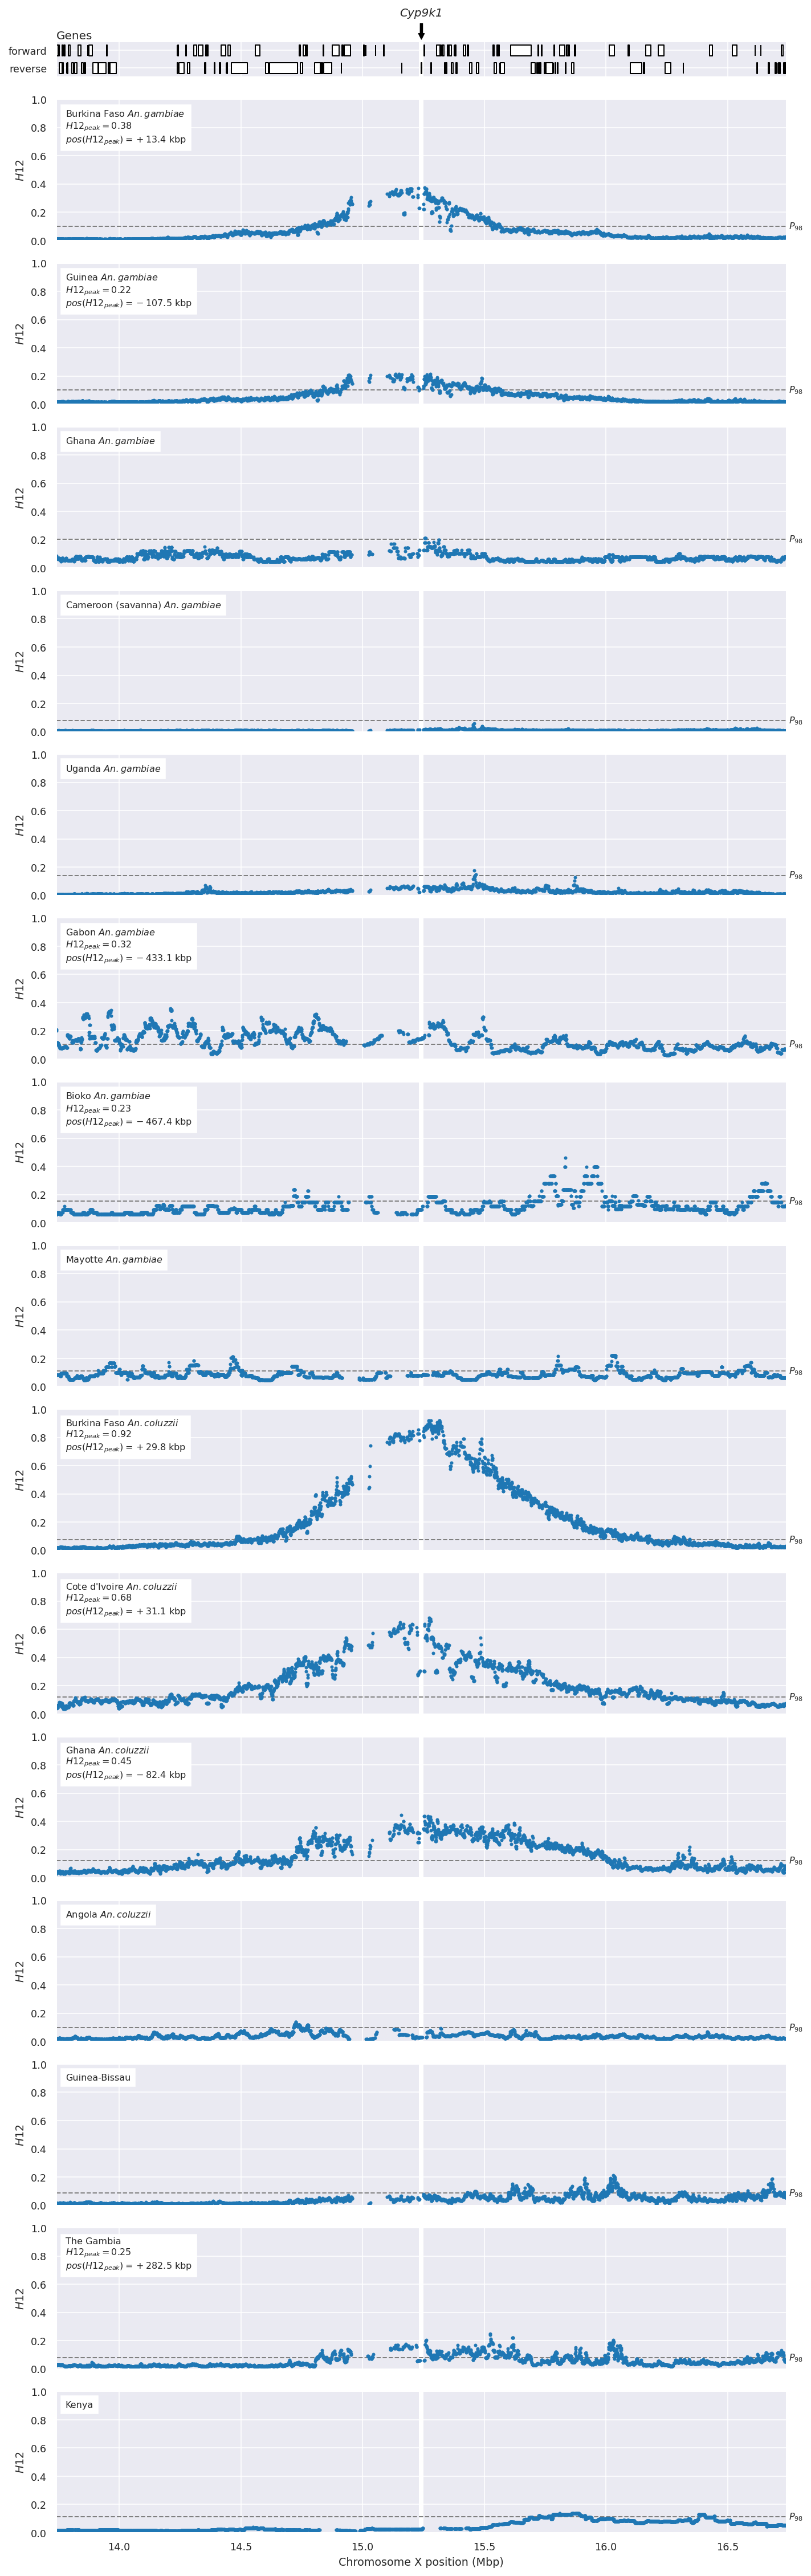

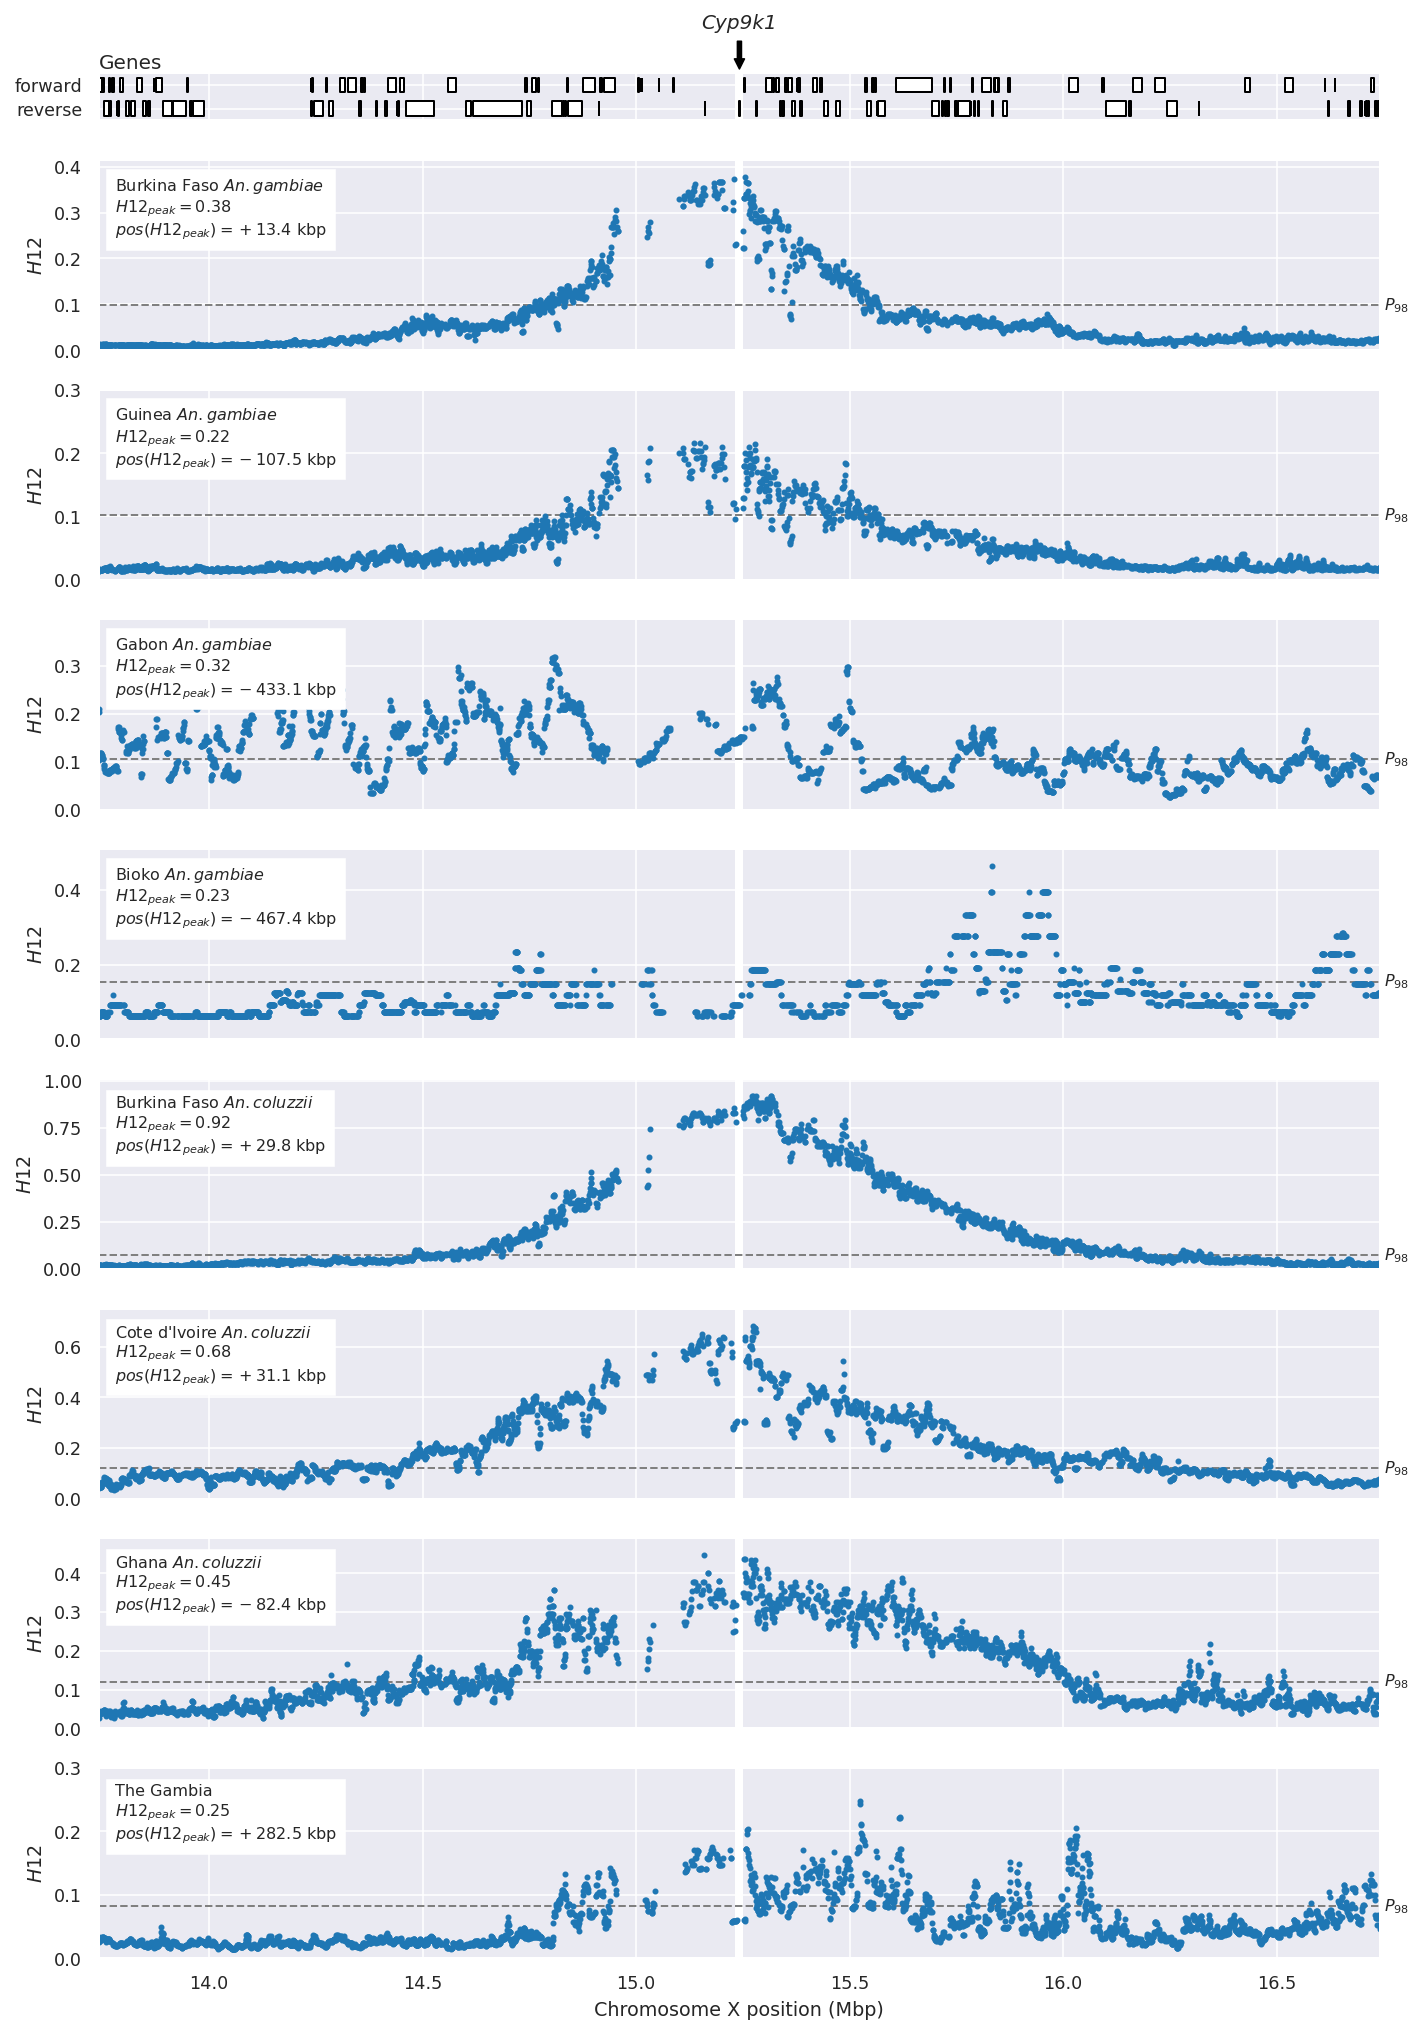

In [27]:
analyse_gene(cyp9k1)

## *Vgsc*

In [28]:
vgsc

seqid                            2L
source                   VectorBase
type                           gene
start                       2358158
end                         2431617
score                            -1
strand                            +
phase                            -1
Name                           Vgsc
biotype              protein_coding
chromosome                        2
chromosome_start           63903263
chromosome_end             63976722
chromosome_center         6.394e+07
Name: AGAP004707, dtype: object

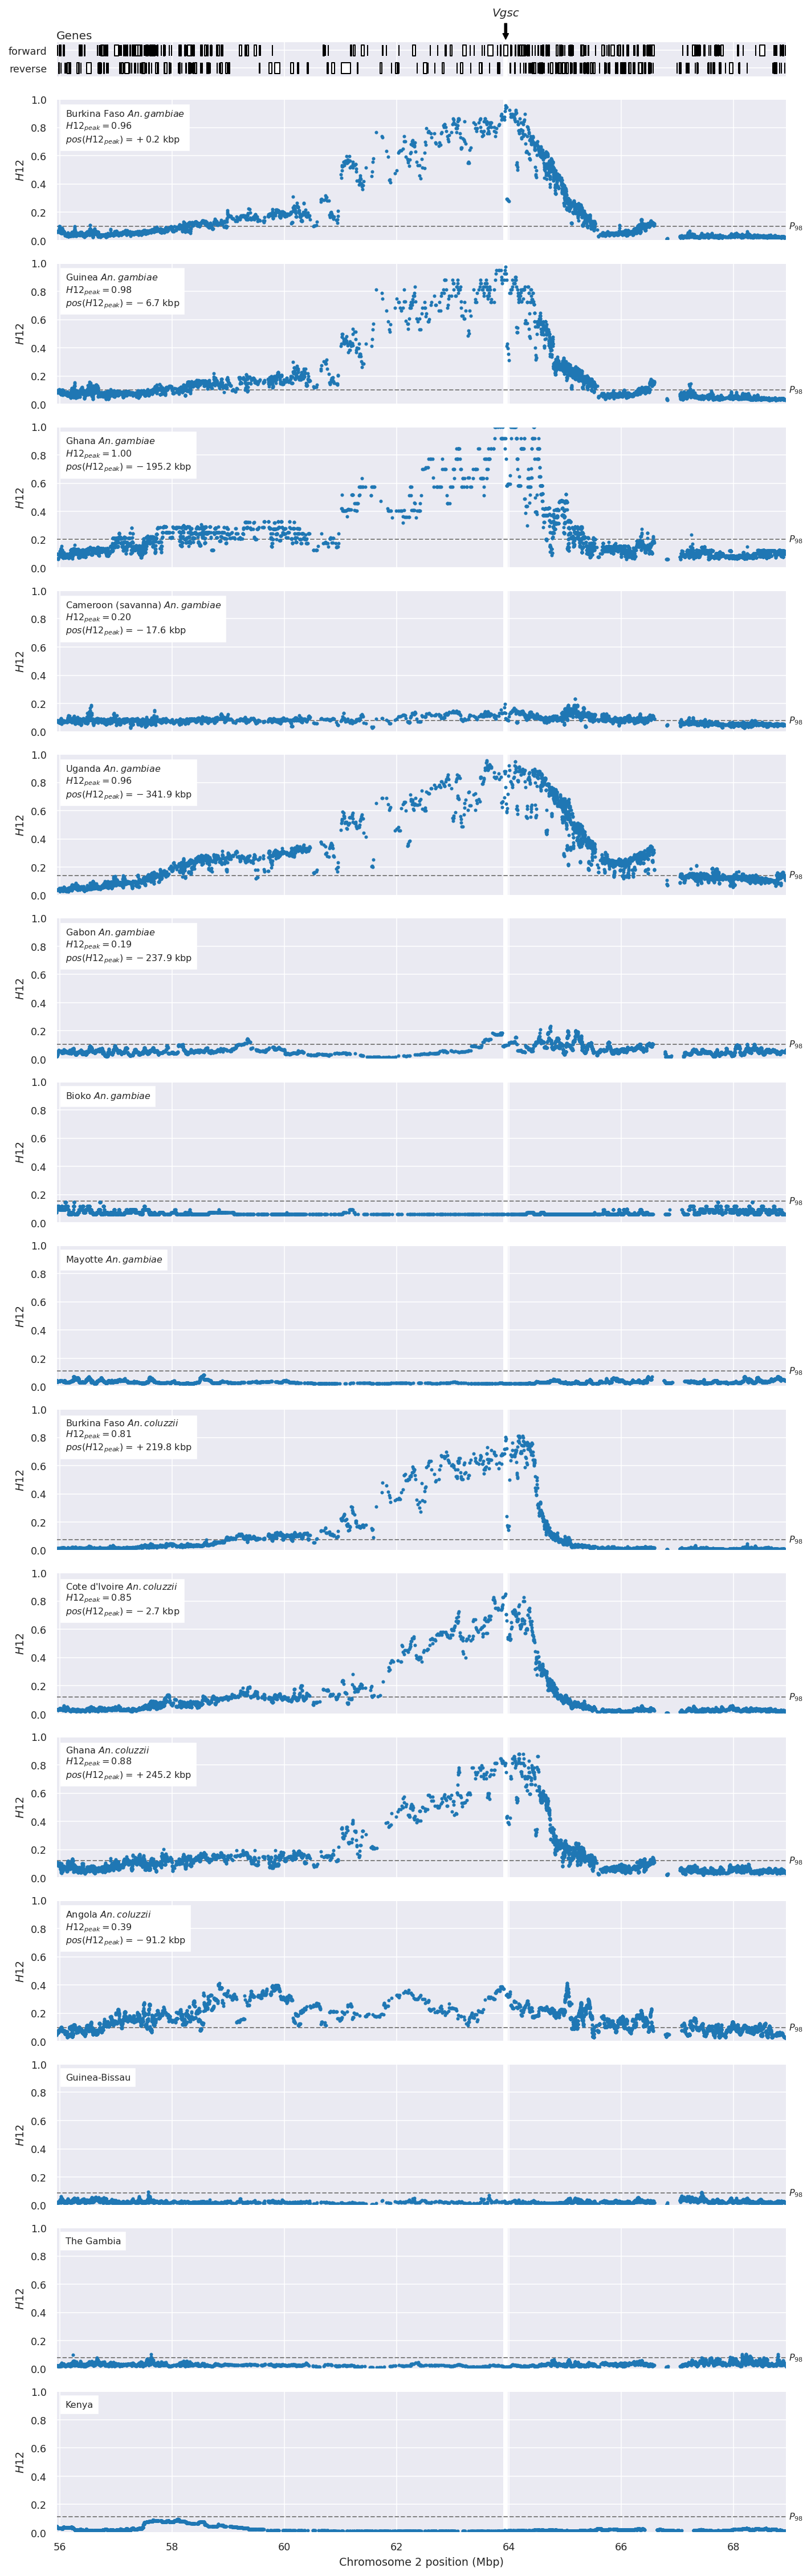

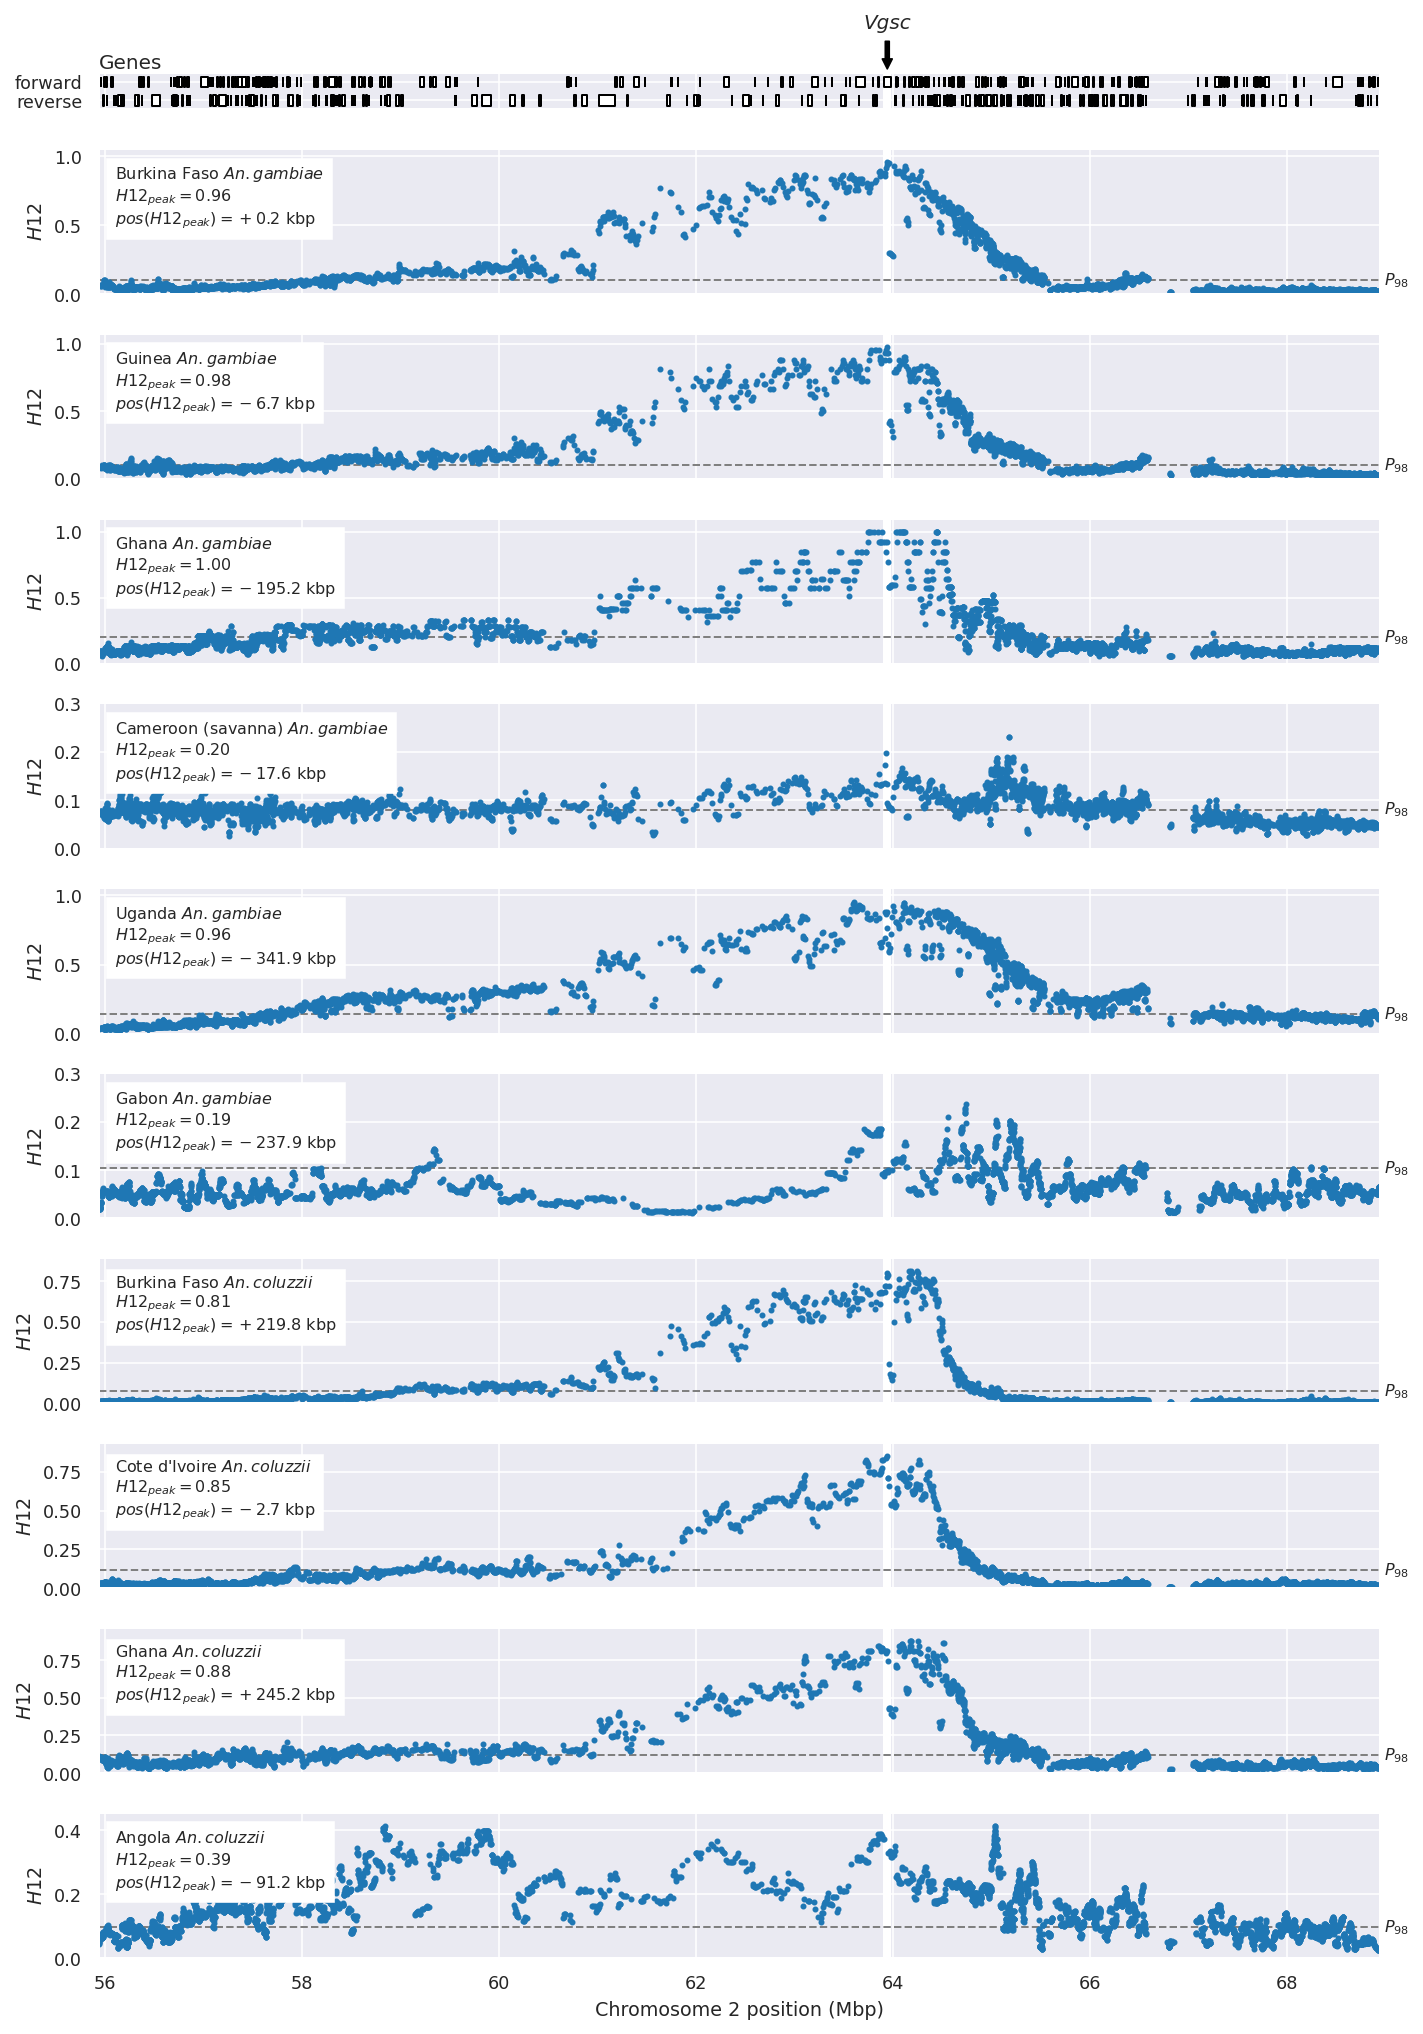

In [29]:
analyse_gene(vgsc, flank=(8, 5))

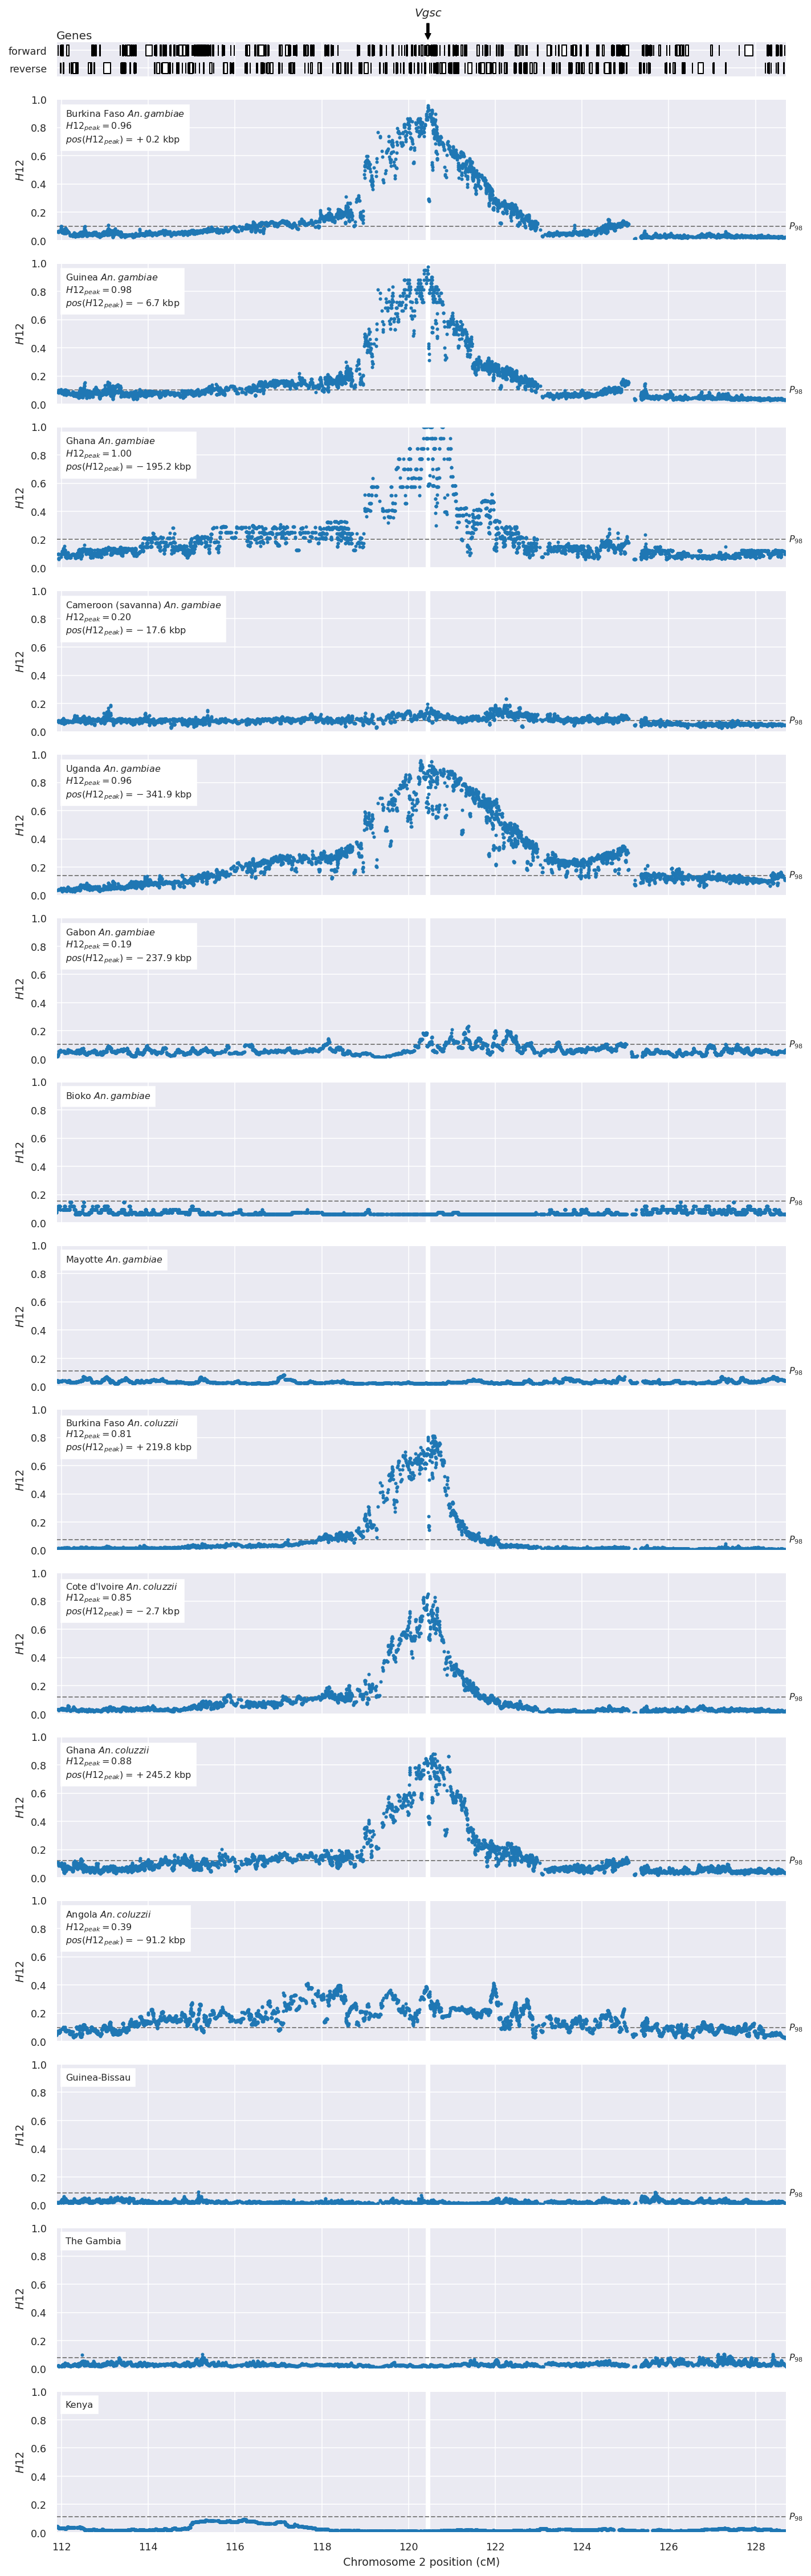

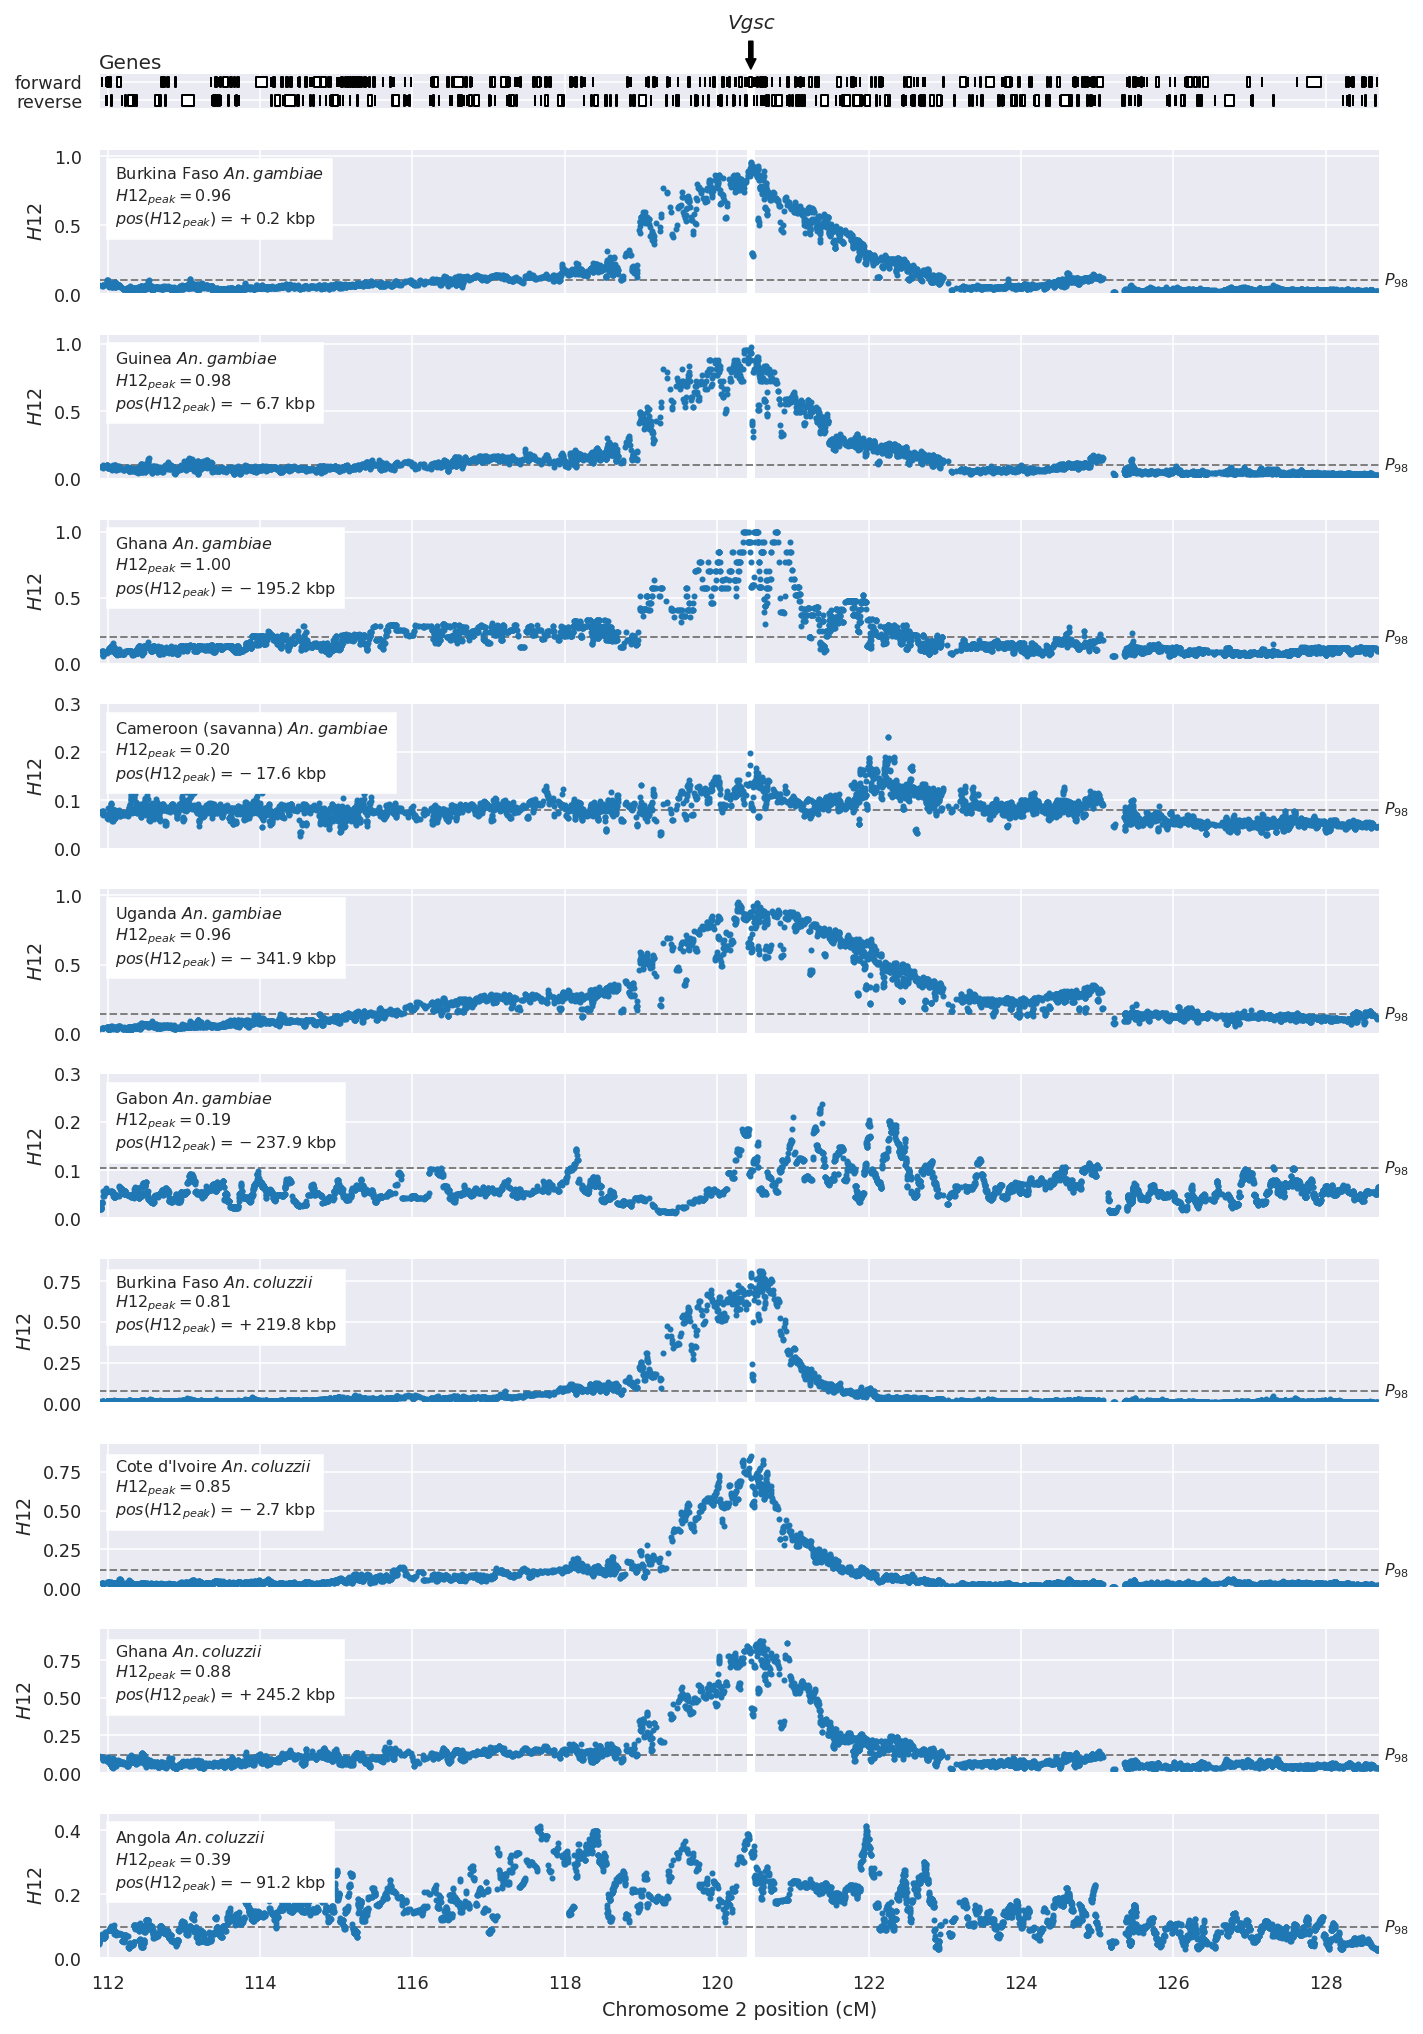

In [30]:
analyse_gene(vgsc, flank=(8, 5), genetic_distance=True)

## *Gaba*

In [31]:
gaba

seqid                            2L
source                   VectorBase
type                           gene
start                      25363652
end                        25434556
score                            -1
strand                            +
phase                            -1
Name                           Gaba
biotype              protein_coding
chromosome                        2
chromosome_start           86908757
chromosome_end             86979661
chromosome_center       8.69442e+07
Name: AGAP006028, dtype: object

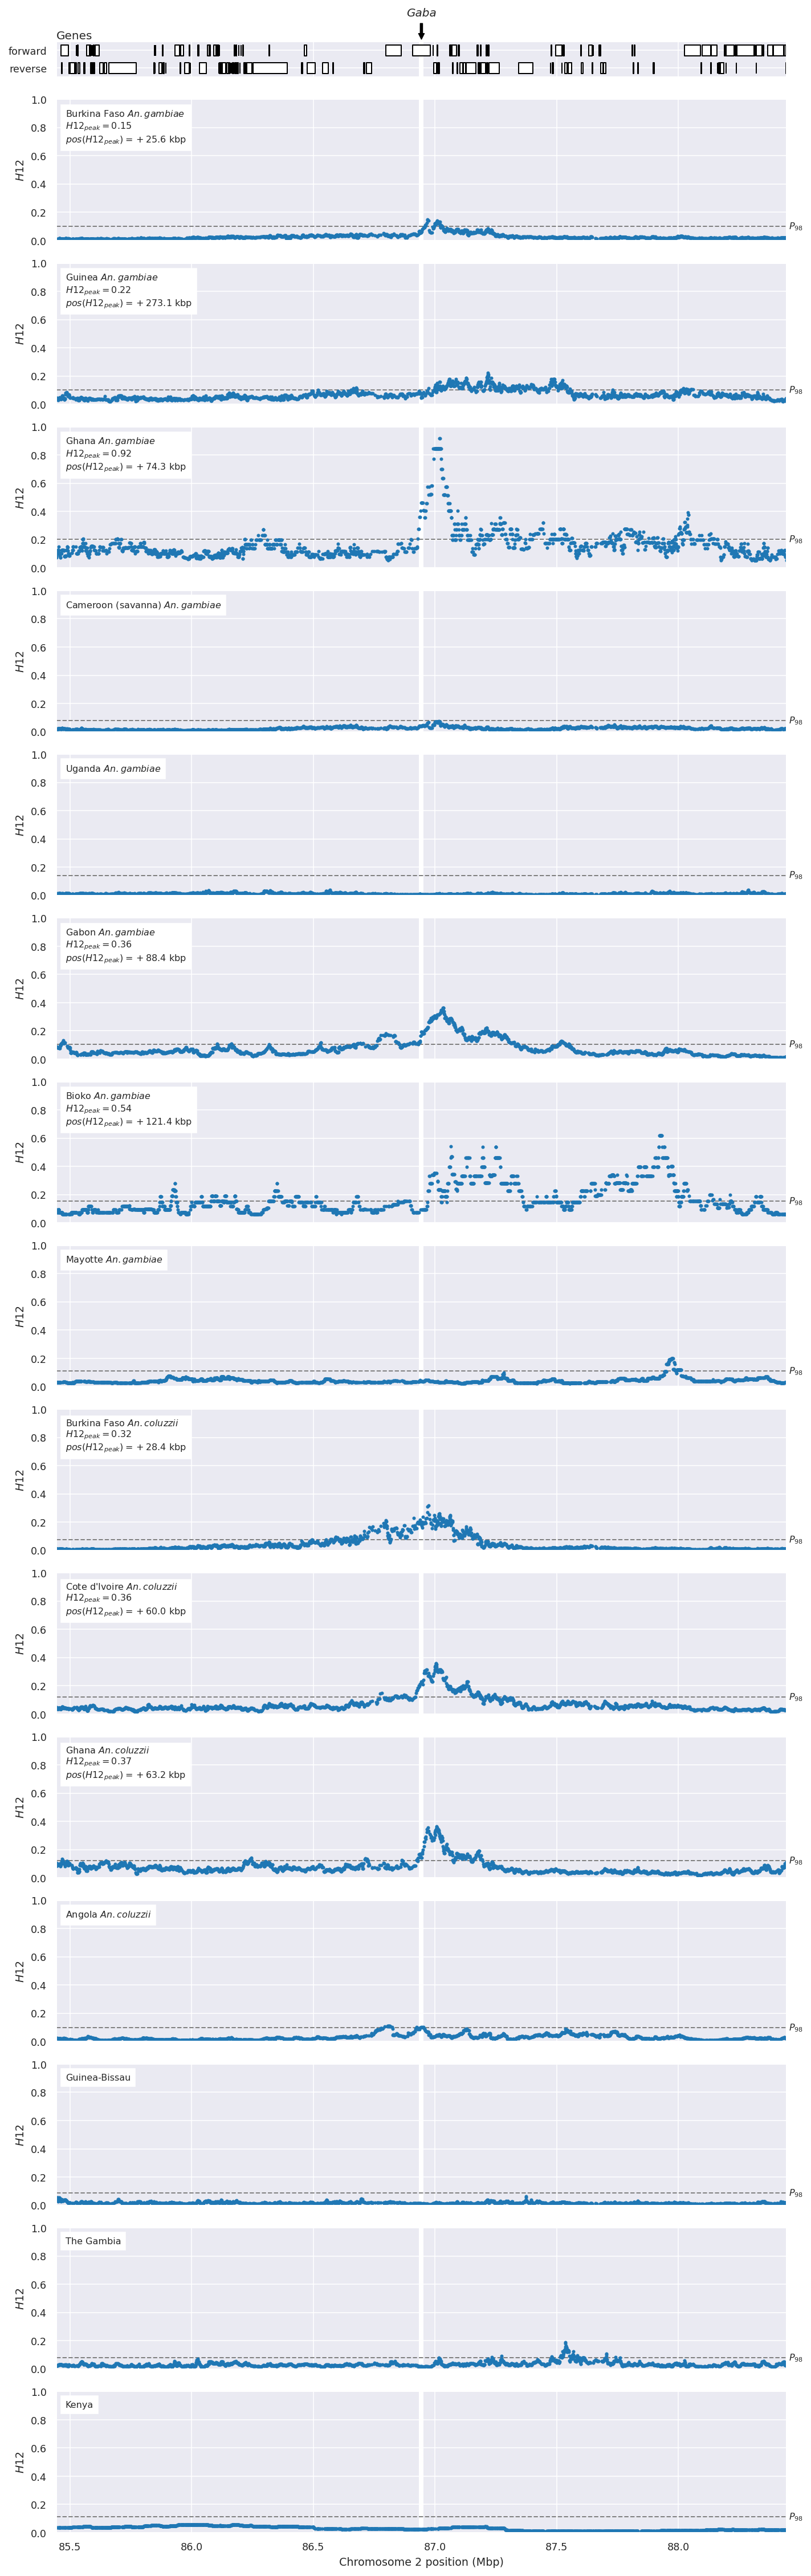

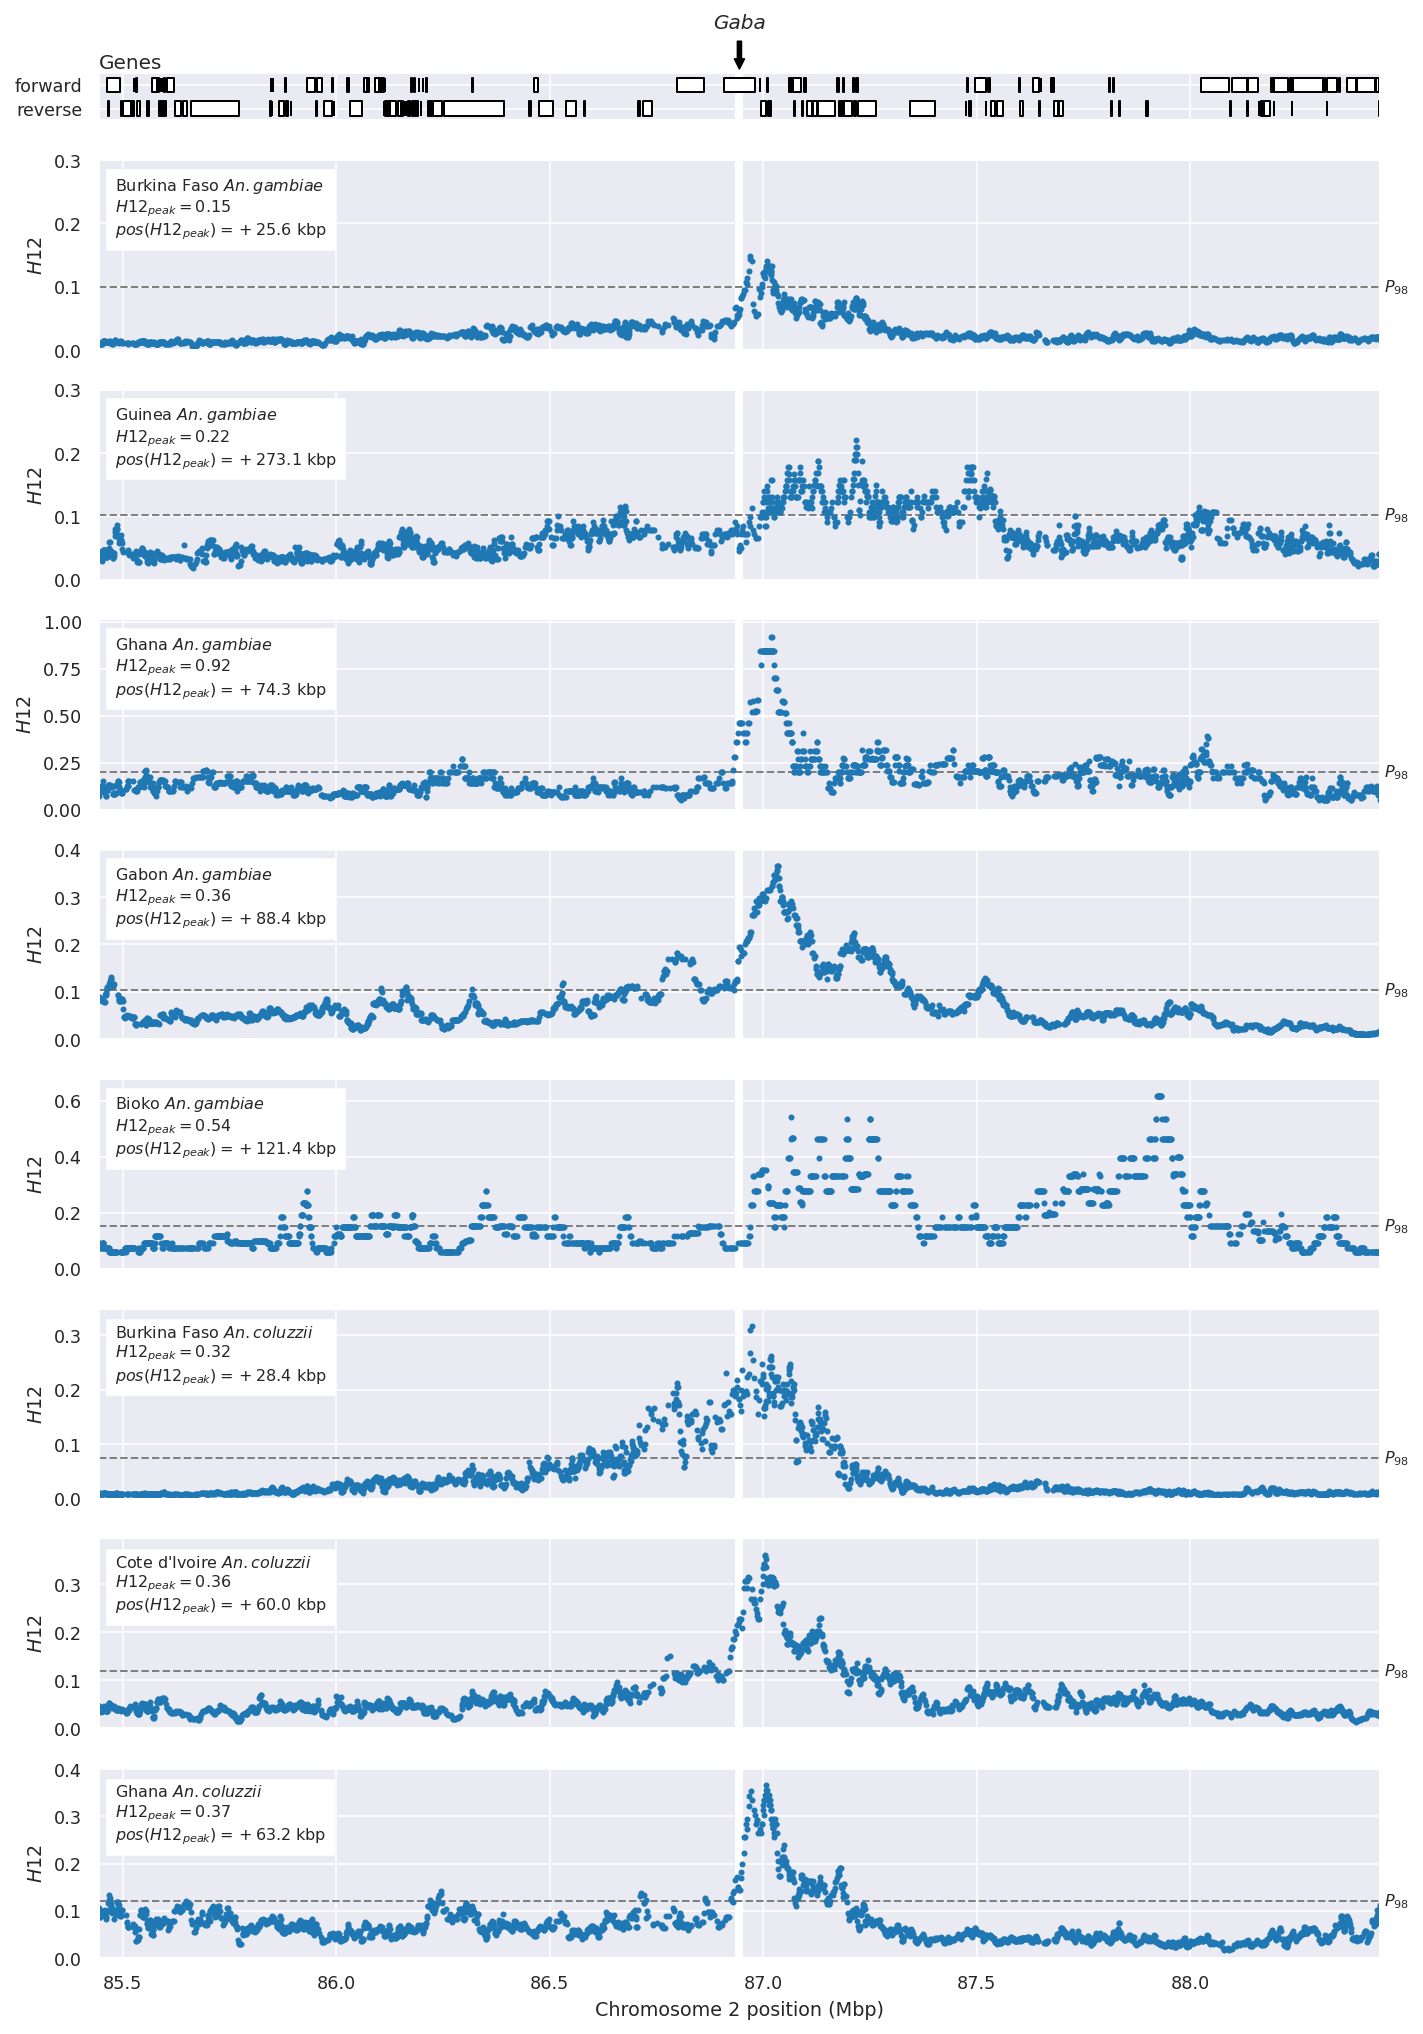

In [32]:
analyse_gene(gaba)

## *Ace1*

In [33]:
ace1

seqid                            2R
source                   VectorBase
type                           gene
start                       3483099
end                         3497400
score                            -1
strand                            +
phase                            -1
Name                           Ace1
biotype              protein_coding
chromosome                        2
chromosome_start            3483099
chromosome_end              3497400
chromosome_center       3.49025e+06
Name: AGAP001356, dtype: object

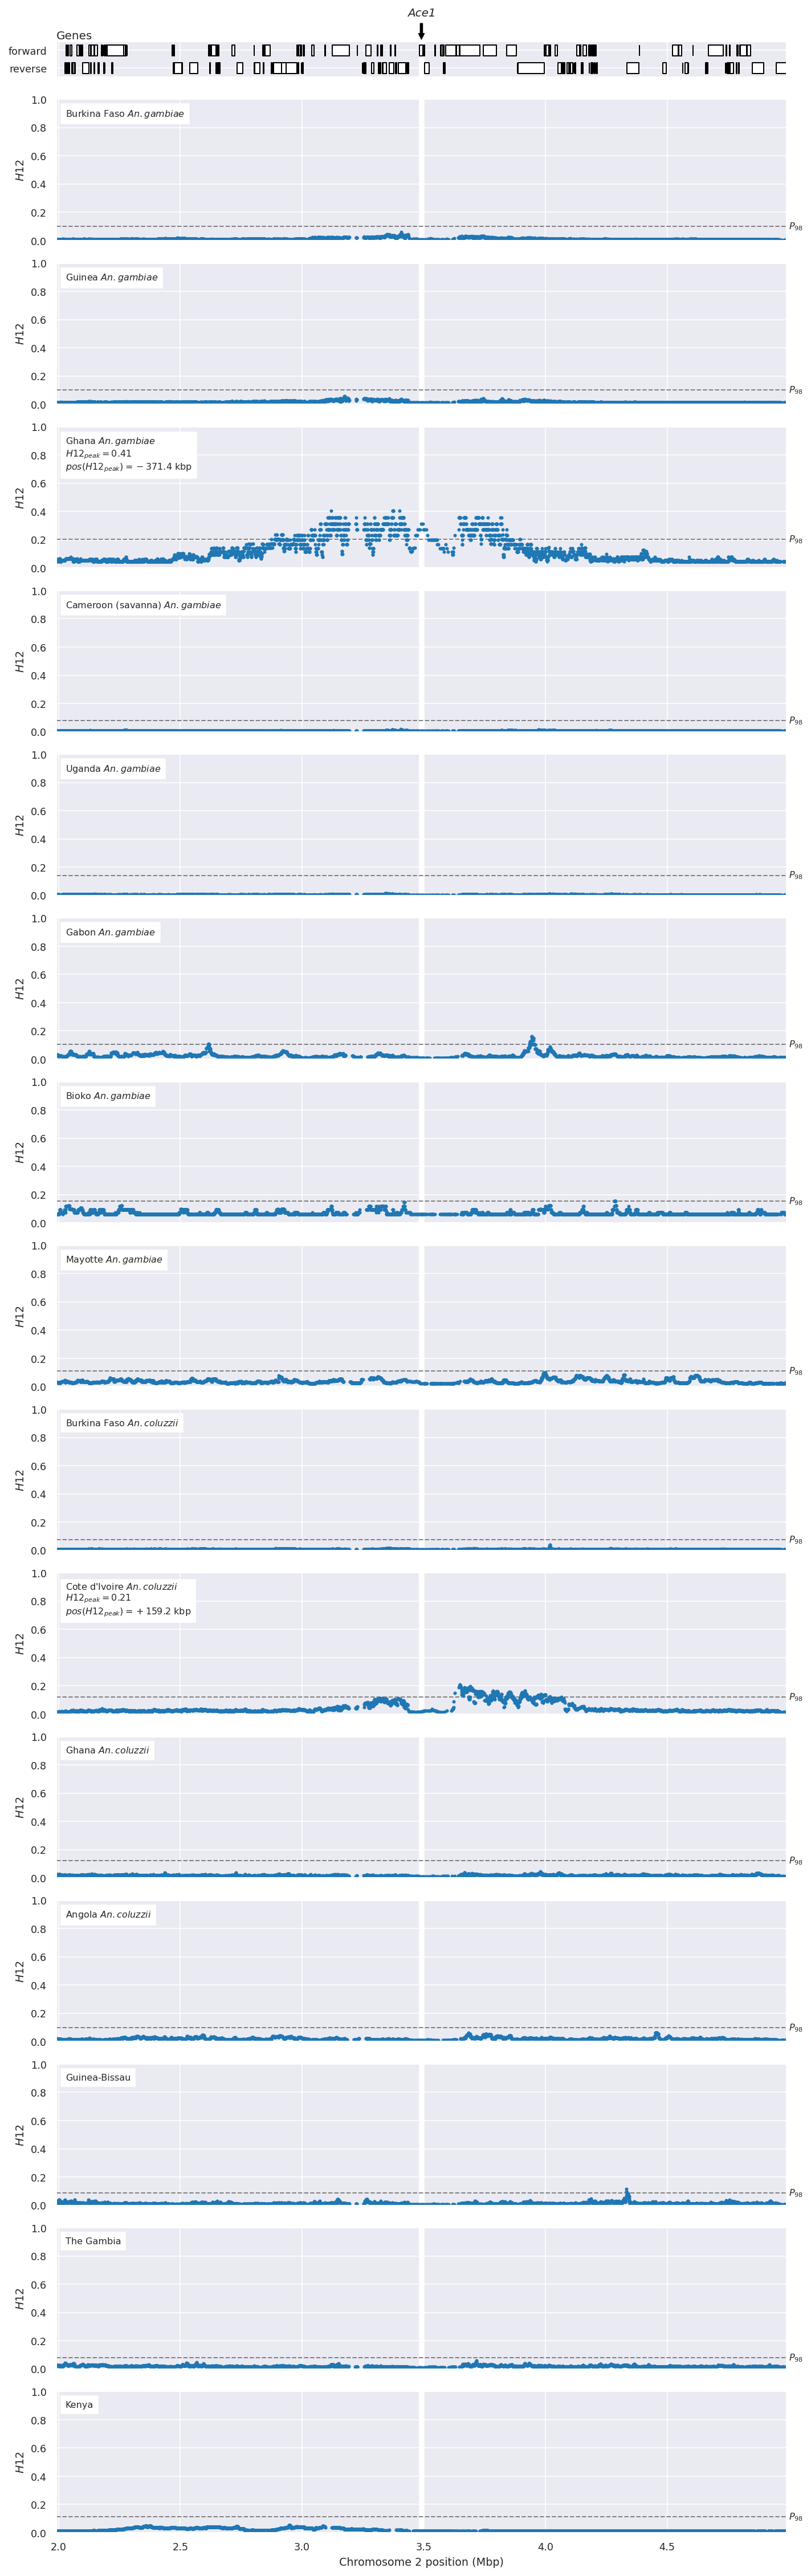

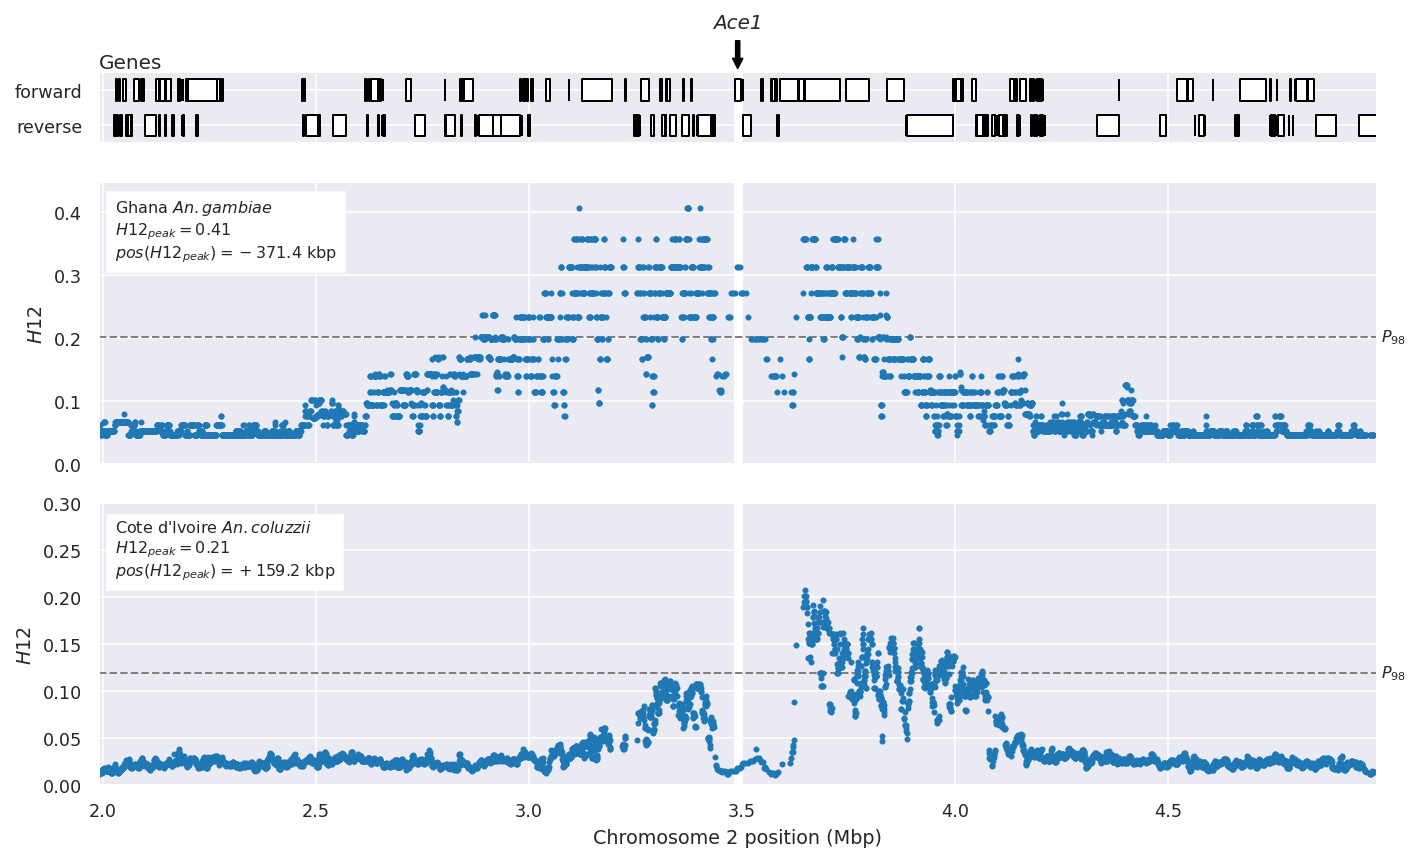

In [34]:
analyse_gene(ace1)

## Compile statistics

In [35]:
analyse_peak_stats(all_stats, slug='h12', label='H12')